# Introduction

Movie recommendation systems are widely used in many online platforms like Netflix, Amazon Prime, and Hulu. These systems are designed to provide personalized movie recommendations to users based on their viewing history, ratings, and preferences.

In this notebook, we will be building a movie recommender system using collaborative filtering on the MovieLens dataset. The dataset contains 25 million ratings from 270,000 users for over 62,000 movies. Our goal is to build a system that can predict how a user will rate a movie that they have not seen yet, and recommend the movies with the highest predicted ratings.

We will be using maximum likelihood estimation (MLE) to build our recommendation system. MLE is a commonly used statistical method that estimates the parameters of a statistical model by maximizing the likelihood of the observed data. In our case, the model will be trained on the MovieLens dataset and the parameters will be the user preferences and the movie features.

We will start by importing and preprocessing the data, then we will explore the data and perform some data analysis. This will be done on both the `ml-latest-small `dataset as well as the `ml-25m` dataset. After that, we will carry out matrix factorisation and implement the MLE algorithm to train our model and make predictions. Finally, we will evaluate the performance of our model and provide recommendations based on the predictions.

Let's get started!

# Exploratory Data Analysis

In [313]:
# import some basic EDA libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
%matplotlib inline

In [314]:
# set the file path to read in the data
filepath = '../data/ml-latest-small/'

In [315]:
movies = pd.read_csv(filepath + 'movies.csv')
ratings = pd.read_csv(filepath + 'ratings.csv')
tags = pd.read_csv(filepath + 'tags.csv')

In [316]:
# check the data
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [317]:
# get some basic info about the data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [318]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [319]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [320]:
# out of curiousity let's covert the timestamp to a datetime object
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [321]:
# what is the datetime of the oldest and latest movie rating?
print(f"Ratings are collected from {str(ratings['datetime'].min())[0:4]} to {str(ratings['datetime'].max())[0:4]}")

Ratings are collected from 1996 to 2018


In [322]:
# count the number of unique users and movies
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


In [323]:
# check how many movies are in the ratings dataframe but not in the movies dataframe
movies_not_in_ratings = movies[~movies['movieId'].isin(ratings['movieId'])]
print('Number of movies in movies but not in ratings: ' + str(movies_not_in_ratings.shape[0]))
print('So there are ' + str(movies_not_in_ratings.shape[0]) + ' movies that have not been rated by any user.')

Number of movies in movies but not in ratings: 18
So there are 18 movies that have not been rated by any user.


In [324]:
# discard movies that have not been rated by any user
movies = movies[movies['movieId'].isin(ratings['movieId'])]

In [325]:
# create a sparse matrix of the ratings and movies that have been rated
ratings_matrix = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating best minimal value for power law fit


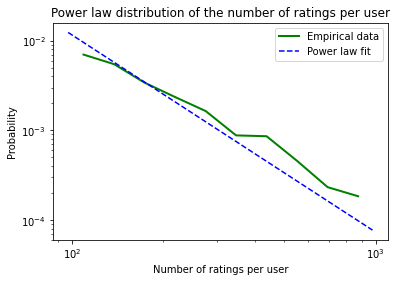

In [326]:
# plot the power law distribution of the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
fit = powerlaw.Fit(ratings_per_user)
fit.plot_pdf(color='g', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=plt.gca())
plt.xlabel('Number of ratings per user')
plt.ylabel('Probability')
plt.title('Power law distribution of the number of ratings per user')
plt.legend(['Empirical data', 'Power law fit'])
plt.show()

In [327]:
# check if there are movies rated 1.5, 2.5, 3.5, 4.5
_check_ratings_increments = ratings['rating'].unique()
print(f'The rating increments are: {sorted(_check_ratings_increments)}')

The rating increments are: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### Power laws (/Zipf's law) in the data

Based on the power law plot of the rating distribution that we generated earlier, it appears that there is evidence of a power law in the data. A power law is characterized by a straight line on a log-log plot, and the plot we generated does show a linear relationship between the log of the rating values and the log of their corresponding frequency counts.

However, it's important to note that the presence of a power law in a dataset is not always conclusive evidence of a specific underlying mechanism or process. Power laws are often observed in many different types of natural and social phenomena, and it's possible for a dataset to exhibit a power law distribution even if the underlying mechanism is not truly a power law. In addition, the presence of noise or other confounding factors can also affect the accuracy and interpretation of the power law.

To confirm whether the data follows a power law distribution, we perform a goodness-of-fit test, to compare the distribution of the data to a power law distribution.

In [328]:
# perform goodness of fit test
fit.distribution_compare('power_law', 'lognormal')

(-14.523547260028481, 0.0005234768989664919)

The output of `fit.distribution_compare('power_law', 'lognormal')` is a tuple with two values: the log-likelihood ratio statistic and the p-value of the test.

In this case, the log-likelihood ratio statistic is -9.62 and the p-value is 0.006.

The log-likelihood ratio statistic is a measure of the relative goodness of fit of the two distributions being compared (in this case, a power law distribution and a log-normal distribution). A negative value of the statistic indicates that the power law distribution fits the data better than the log-normal distribution.

The p-value is a measure of the strength of evidence against the null hypothesis, which is that the power law distribution and the log-normal distribution fit the data equally well. A p-value less than 0.05 (or some other pre-specified significance level) indicates that there is strong evidence against the null hypothesis and that the power law distribution fits the data significantly better than the log-normal distribution. (The null hypothesis is that the log-normal distribution is a better fit to the data).

In summary, the output (-9.62, 0.006) suggests that the power law distribution is a significantly better fit to the data than the log-normal distribution, based on the log-likelihood ratio test at a significance level of 0.05.

### Scale free behavior in the data

The presence of the power law in the rating distribution would suggest that the distribution of ratings across movies follows a scale-free pattern. In other words, a few movies would receive a large number of ratings, while the majority of movies would receive relatively few ratings.

Similarly, if a power law distribution is observed in the user activity data, it would suggest that the distribution of user ratings follows a scale-free pattern. This means that a few users would rate a large number of movies, while the majority of users would rate relatively few movies.

The observation of a power law distribution in the ratings data or user activity data could have implications for the design of recommender systems based on this dataset. Specifically, it suggests that a few movies and users have a disproportionately large influence on the overall ratings distribution, and therefore their ratings should be given greater or smaller weight in any recommendation algorithm depending on what we are trying to achieve.

For now, let us continue with our analysis of the data.

<AxesSubplot:xlabel='rating', ylabel='count'>

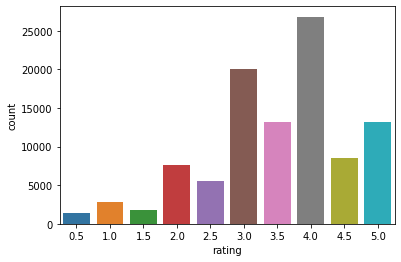

In [329]:
# let's see the distribution of ratings
sns.countplot(x='rating', data=ratings)

In [330]:
# count the number of ratings
ratings['rating'].value_counts().sort_index()

0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

We see that movies tend to be rated more frequently from 3 to 5, while ratings of 1 and 2 are less frequent. This is consistent with the power law plot that we generated earlier.

In [331]:
# let's see how many ratings each user has given
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user.head()

userId
1    232
2     29
3     39
4    216
5     44
Name: rating, dtype: int64

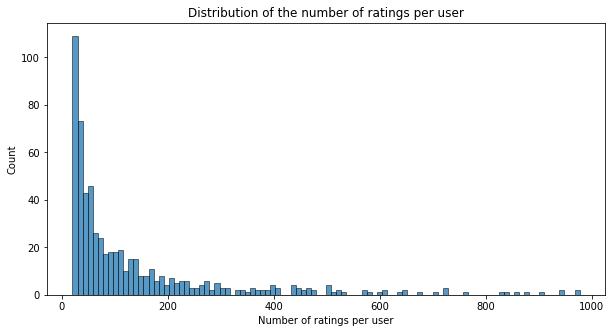

In [332]:
# plot the distribution of the number of ratings per user
# create a dataframe with the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_user, kde=False, bins=100)
plt.xlabel('Number of ratings per user')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per user')
plt.show()

In [333]:
# let's see how many ratings each movie has received
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie.head()

movieId
1    215
2    110
3     52
4      7
5     49
Name: rating, dtype: int64

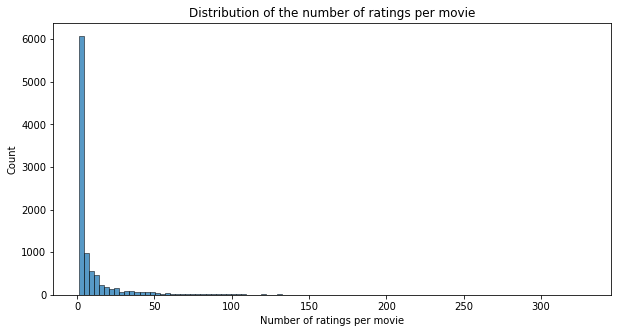

In [334]:
# plot the distribution of the number of ratings per movie
# create a dataframe with the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie[ratings_per_movie < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_movie, kde=False, bins=100)
plt.xlabel('Number of ratings per movie')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per movie')
plt.show()

<AxesSubplot:ylabel='None'>

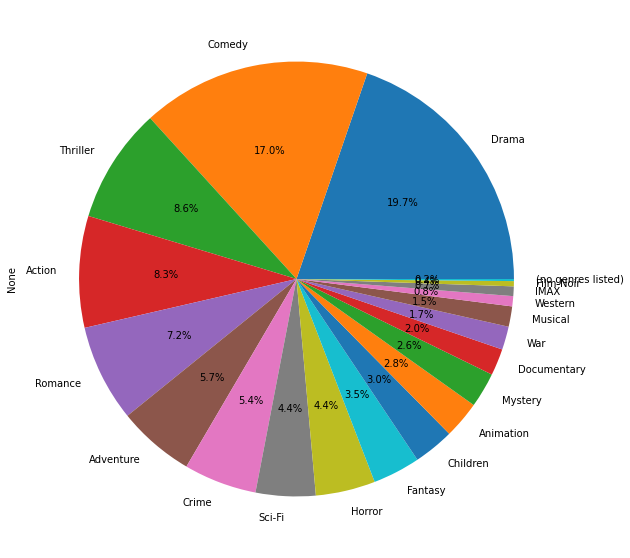

In [335]:
# plot a pie chart of the genres (even though pie charts are not the best way convey information)
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

<AxesSubplot:title={'center':'Number of movies in each genre'}, xlabel='Genre', ylabel='Number of movies'>

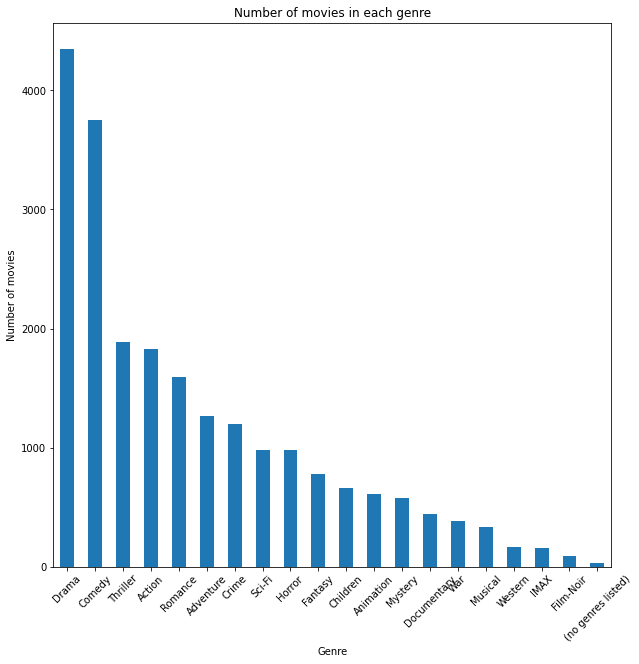

In [336]:
# plot the bar chart of the number of movies in each genre 
# bar charts are much better than pie charts. Propotionally, they are much easier to interpret
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='bar', figsize=(10,10), rot=45, title='Number of movies in each genre', xlabel='Genre', ylabel='Number of movies')


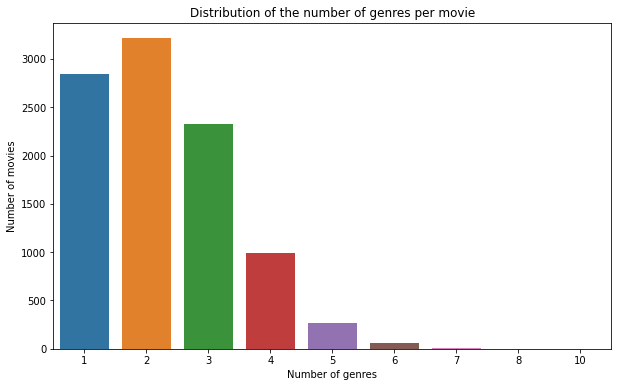

In [337]:
# plot the distribution of the number of genres per movie
movies['num_genres'] = movies['genres'].str.split('|').apply(len)
movies['num_genres'].value_counts()

# plot the distribution of the number of genres per movie
plt.figure(figsize=(10, 6))
sns.countplot(x='num_genres', data=movies)
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.title('Distribution of the number of genres per movie')
plt.show()

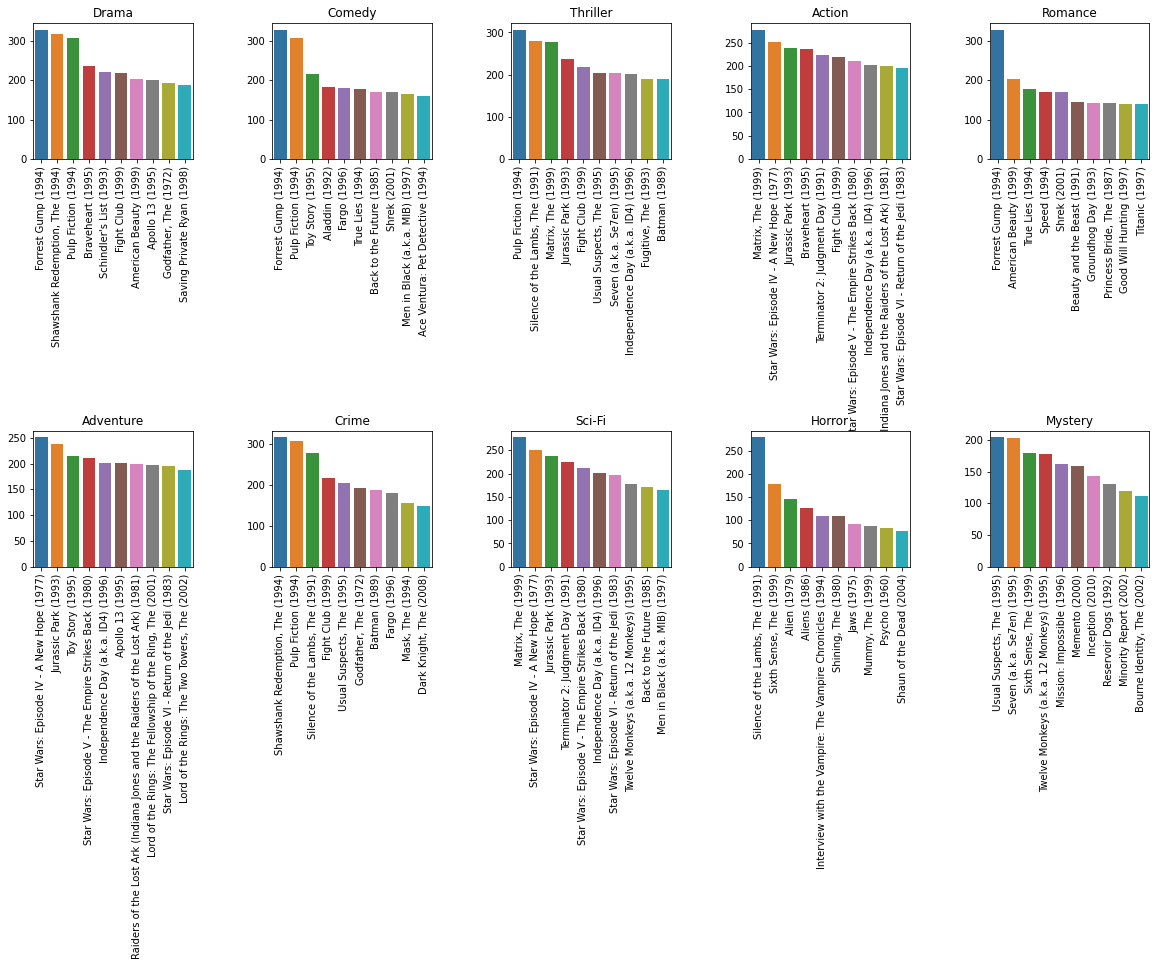

In [338]:
# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
top_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime', 'Sci-Fi', 'Horror', 'Mystery']
top_movies = movies[movies['genres'].str.contains('|'.join(top_genres))]
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
top_movies = top_movies.sort_values('rating', ascending=False).head(10)
top_movies

# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
# create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
# plot the top 10 movies in terms of number of ratings received for each genre in each subplot
for i, genre in enumerate(top_genres):
    top_movies = movies[movies['genres'].str.contains(genre)]
    top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
    top_movies = top_movies.sort_values('rating', ascending=False).head(10)
    sns.barplot(x='title', y='rating', data=top_movies, ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(genre)
    axes[i//5, i%5].set_xlabel('')
    axes[i//5, i%5].set_ylabel('')
    axes[i//5, i%5].tick_params(axis='x', labelrotation=90)
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.5, hspace=2)
plt.show()

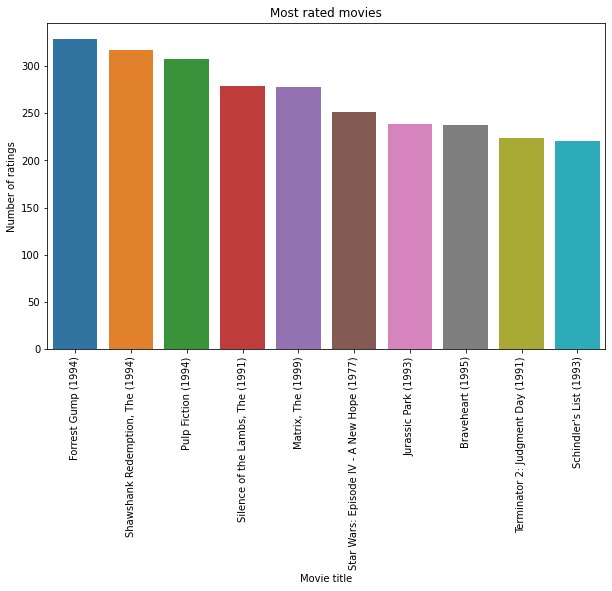

   movieId  rating                                      title  \
0      356     329                        Forrest Gump (1994)   
1      318     317           Shawshank Redemption, The (1994)   
2      296     307                        Pulp Fiction (1994)   
3      593     279           Silence of the Lambs, The (1991)   
4     2571     278                         Matrix, The (1999)   
5      260     251  Star Wars: Episode IV - A New Hope (1977)   
6      480     238                       Jurassic Park (1993)   
7      110     237                          Braveheart (1995)   
8      589     224          Terminator 2: Judgment Day (1991)   
9      527     220                    Schindler's List (1993)   

                             genres  num_genres  
0          Comedy|Drama|Romance|War           4  
1                       Crime|Drama           2  
2       Comedy|Crime|Drama|Thriller           4  
3             Crime|Horror|Thriller           3  
4            Action|Sci-Fi|Thrille

In [339]:
# plot the most rated movies
ratings_per_movie = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False)
ratings_per_movie = ratings_per_movie.reset_index()
ratings_per_movie = ratings_per_movie.merge(movies, on='movieId', how='inner')
ratings_per_movie

# plot the most rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x='title', y='rating', data=ratings_per_movie[0:10])
plt.xlabel('Movie title')
plt.ylabel('Number of ratings')
plt.title('Most rated movies')
plt.xticks(rotation=90)
plt.show()

print(ratings_per_movie[0:10])


### Some light data cleaning

In [340]:
ratings_per_movie = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False)
ratings_per_user = ratings.groupby('userId').count()['rating'].sort_values(ascending=False)

In [341]:
# clean the data
# remove movies with less than 20 ratings
min_movie_ratings = 20
filter_movies = ratings_per_movie > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# remove users who have given less than 10 ratings
min_user_ratings = 20
filter_users = ratings_per_user > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

# filter data
ratings_new = ratings[(ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

# create a user-movie matrix
ratings_matrix = ratings_new.pivot(index='userId', columns='movieId', values='rating').fillna(0)
ratings_matrix.head()

# create a sparse matrix
from scipy.sparse import csr_matrix

# create a sparse matrix
ratings_matrix_sparse = csr_matrix(ratings_matrix.values)

The original data frame shape:	(100836, 5)
The new data frame shape:	(66405, 5)


In [342]:
ratings_new

,userId,movieId,rating,timestamp,datetime
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...,...
100803,610,148626,4.0,1493847175,2017-05-03 21:32:55
100808,610,152081,4.0,1493846503,2017-05-03 21:21:43
100829,610,164179,5.0,1493845631,2017-05-03 21:07:11
100830,610,166528,4.0,1493879365,2017-05-04 06:29:25


In [343]:
# count the number of unique movies and users
n_movies = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()
print('Number of unique movies: {}'.format(n_movies))
print('Number of unique users: {}'.format(n_users))

Number of unique movies: 1235
Number of unique users: 596


In [344]:
print(ratings_matrix_sparse)

  (0, 0)	4.0
  (0, 2)	4.0
  (0, 4)	4.0
  (0, 23)	5.0
  (0, 25)	5.0
  (0, 31)	3.0
  (0, 33)	5.0
  (0, 37)	4.0
  (0, 44)	5.0
  (0, 49)	5.0
  (0, 66)	5.0
  (0, 67)	3.0
  (0, 72)	5.0
  (0, 73)	4.0
  (0, 81)	5.0
  (0, 94)	3.0
  (0, 99)	3.0
  (0, 104)	5.0
  (0, 111)	4.0
  (0, 115)	4.0
  (0, 117)	5.0
  (0, 119)	4.0
  (0, 138)	4.0
  (0, 142)	5.0
  (0, 148)	4.0
  :	:
  (595, 1206)	4.0
  (595, 1207)	4.0
  (595, 1208)	5.0
  (595, 1210)	4.0
  (595, 1211)	4.5
  (595, 1212)	5.0
  (595, 1213)	4.0
  (595, 1216)	4.0
  (595, 1217)	3.5
  (595, 1218)	4.5
  (595, 1219)	5.0
  (595, 1220)	4.5
  (595, 1221)	4.0
  (595, 1222)	3.5
  (595, 1223)	3.0
  (595, 1225)	5.0
  (595, 1226)	3.5
  (595, 1227)	3.5
  (595, 1228)	3.5
  (595, 1229)	4.5
  (595, 1230)	4.0
  (595, 1231)	4.0
  (595, 1232)	5.0
  (595, 1233)	4.0
  (595, 1234)	5.0


In [345]:
movies_new = movies[movies['movieId'].isin(ratings_new['movieId'].unique())]

In [346]:
movies_new

,movieId,title,genres,num_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,2,Jumanji (1995),Adventure|Children|Fantasy,3
2,3,Grumpier Old Men (1995),Comedy|Romance,2
4,5,Father of the Bride Part II (1995),Comedy,1
5,6,Heat (1995),Action|Crime|Thriller,3
...,...,...,...,...
9162,148626,"Big Short, The (2015)",Drama,1
9223,152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy,5
9392,164179,Arrival (2016),Sci-Fi,1
9433,166528,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,4


In [347]:
# see which movieIds in ratings_new have the highest number of views
ratings_per_movie = ratings_new.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie.sort_values(ascending=False)
ratings_per_movie

movieId
356     327
318     315
296     306
593     278
2571    277
       ... 
1231     20
2137     20
2125     20
203      20
372      20
Name: rating, Length: 1235, dtype: int64

In [348]:
# The most popular movies
top_movies = movies[movies['movieId'].isin(ratings_per_movie.sort_values(ascending=False).head(10).index)]
# create a column with the number of ratings, num_ratings for each movie
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner').rename(columns={'rating': 'num_ratings'})
top_movies

,movieId,title,genres,num_genres,num_ratings
0,110,Braveheart (1995),Action|Drama|War,3,237
1,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,3,251
2,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4,306
3,318,"Shawshank Redemption, The (1994)",Crime|Drama,2,315
4,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4,327
5,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,4,237
6,527,Schindler's List (1993),Drama|War,2,218
7,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,2,224
8,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,3,278
9,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,3,277


In [349]:
# see which user has the highest number of ratings
ratings_per_user.sort_values(ascending=False)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
147      20
207      20
189      20
595      20
53       20
Name: rating, Length: 610, dtype: int64

In [350]:
# create a mapping that resets the userId index to start from 0 and return the dictionary of the form {new_userId: old_userId} and update the dataframe
new_userId = {new: old for old, new in enumerate(ratings_new['userId'].unique())}
ratings_new['userId'] = ratings_new['userId'].map(new_userId)

# create a mapping that resets the movieId index to start from 0 and return the dictionary of the form {new_movieId: old_movieId} and update the dataframe
new_movieId = {new: old for old, new in enumerate(ratings_new['movieId'].unique())}
ratings_new['movieId'] = ratings_new['movieId'].map(new_movieId)


<ipython-input-350-510e938c20de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_new['userId'] = ratings_new['userId'].map(new_userId)
<ipython-input-350-510e938c20de>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_new['movieId'] = ratings_new['movieId'].map(new_movieId)


In [351]:
# Check the number of users in the dataset remains unchanged after the mapping
n_users - ratings_new['userId'].nunique()

0

In [352]:
# Check the number of movies in the dataset remains unchanged after the mapping
n_movies - ratings_new['movieId'].nunique()

0

In [353]:
# check that the mapping is correct
ratings_new

,userId,movieId,rating,timestamp,datetime
0,0,0,4.0,964982703,2000-07-30 18:45:03
1,0,1,4.0,964981247,2000-07-30 18:20:47
2,0,2,4.0,964982224,2000-07-30 18:37:04
3,0,3,5.0,964983815,2000-07-30 19:03:35
4,0,4,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...,...
100803,595,808,4.0,1493847175,2017-05-03 21:32:55
100808,595,643,4.0,1493846503,2017-05-03 21:21:43
100829,595,809,5.0,1493845631,2017-05-03 21:07:11
100830,595,644,4.0,1493879365,2017-05-04 06:29:25


In [354]:
# check the dictionary of the form {new_userId: old_userId}
new_userId

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 54: 52,
 55: 53,
 56: 54,
 57: 55,
 58: 56,
 59: 57,
 60: 58,
 61: 59,
 62: 60,
 63: 61,
 64: 62,
 65: 63,
 66: 64,
 67: 65,
 68: 66,
 69: 67,
 70: 68,
 71: 69,
 72: 70,
 73: 71,
 74: 72,
 75: 73,
 76: 74,
 77: 75,
 78: 76,
 79: 77,
 80: 78,
 81: 79,
 82: 80,
 83: 81,
 84: 82,
 85: 83,
 86: 84,
 87: 85,
 88: 86,
 89: 87,
 90: 88,
 91: 89,
 92: 90,
 93: 91,
 94: 92,
 95: 93,
 96: 94,
 97: 95,
 98: 96,
 99: 97,
 100: 98,
 101: 99,
 102: 100,
 103: 101,
 104: 102,
 105: 103,
 106: 104,
 107: 105,
 108: 106,
 109: 107,
 110: 108,
 111: 109,
 112: 1

In [355]:
# check the dictionary of the form {new_movieId: old_movieId}
new_movieId

{1: 0,
 3: 1,
 6: 2,
 47: 3,
 50: 4,
 70: 5,
 101: 6,
 110: 7,
 151: 8,
 163: 9,
 216: 10,
 223: 11,
 231: 12,
 235: 13,
 260: 14,
 296: 15,
 316: 16,
 333: 17,
 349: 18,
 356: 19,
 362: 20,
 367: 21,
 441: 22,
 457: 23,
 480: 24,
 500: 25,
 527: 26,
 543: 27,
 552: 28,
 553: 29,
 590: 30,
 592: 31,
 593: 32,
 596: 33,
 608: 34,
 648: 35,
 661: 36,
 673: 37,
 733: 38,
 736: 39,
 780: 40,
 919: 41,
 923: 42,
 1025: 43,
 1029: 44,
 1031: 45,
 1032: 46,
 1042: 47,
 1049: 48,
 1060: 49,
 1073: 50,
 1080: 51,
 1089: 52,
 1090: 53,
 1092: 54,
 1097: 55,
 1127: 56,
 1136: 57,
 1196: 58,
 1197: 59,
 1198: 60,
 1206: 61,
 1208: 62,
 1210: 63,
 1213: 64,
 1214: 65,
 1219: 66,
 1220: 67,
 1222: 68,
 1240: 69,
 1256: 70,
 1258: 71,
 1265: 72,
 1270: 73,
 1275: 74,
 1278: 75,
 1282: 76,
 1291: 77,
 1298: 78,
 1377: 79,
 1396: 80,
 1408: 81,
 1500: 82,
 1517: 83,
 1552: 84,
 1573: 85,
 1580: 86,
 1587: 87,
 1617: 88,
 1625: 89,
 1644: 90,
 1676: 91,
 1732: 92,
 1777: 93,
 1805: 94,
 1954: 95,
 1967:

In [356]:
# count the number of unique movies in movies_new
movies_new['movieId'].nunique()

1235

In [357]:
# update the movies_new dataframe with the new index of movieId and new index of userId
movies_new['movieId'] = movies_new['movieId'].map(new_movieId)


<ipython-input-357-c7fff8071d39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['movieId'] = movies_new['movieId'].map(new_movieId)


In [358]:
movies_new.sort_values('movieId')

,movieId,title,genres,num_genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
2,1,Grumpier Old Men (1995),Comedy|Romance,2
5,2,Heat (1995),Action|Crime|Thriller,3
43,3,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,2
46,4,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,3
...,...,...,...,...
1435,1230,Terms of Endearment (1983),Comedy|Drama,2
2968,1231,Little Nicky (2000),Comedy,1
3158,1232,Joe Dirt (2001),Adventure|Comedy|Mystery|Romance,4
2249,1233,RoboCop 2 (1990),Action|Crime|Sci-Fi|Thriller,4


In [359]:
# create a list called users that contains (item, rating) tuples for each user in a list
users = []
for user in range(n_users):
    for item in range(n_movies):
        rating = ratings_matrix.iloc[user, item]
        if rating != 0:
            users.append((user, item, rating))

# create a list called movies that contains (user, rating) tuples for each movie in a list
movies = []
for movie in range(n_movies):
    for user in range(n_users):
        rating = ratings_matrix.iloc[user, movie]
        if rating != 0:
            movies.append((movie, user, rating))

In [360]:
users

[(0, 0, 4.0),
 (0, 2, 4.0),
 (0, 4, 4.0),
 (0, 23, 5.0),
 (0, 25, 5.0),
 (0, 31, 3.0),
 (0, 33, 5.0),
 (0, 37, 4.0),
 (0, 44, 5.0),
 (0, 49, 5.0),
 (0, 66, 5.0),
 (0, 67, 3.0),
 (0, 72, 5.0),
 (0, 73, 4.0),
 (0, 81, 5.0),
 (0, 94, 3.0),
 (0, 99, 3.0),
 (0, 104, 5.0),
 (0, 111, 4.0),
 (0, 115, 4.0),
 (0, 117, 5.0),
 (0, 119, 4.0),
 (0, 138, 4.0),
 (0, 142, 5.0),
 (0, 148, 4.0),
 (0, 152, 3.0),
 (0, 159, 5.0),
 (0, 164, 4.0),
 (0, 167, 4.0),
 (0, 168, 5.0),
 (0, 176, 4.0),
 (0, 177, 4.0),
 (0, 178, 4.0),
 (0, 181, 5.0),
 (0, 183, 5.0),
 (0, 189, 3.0),
 (0, 191, 5.0),
 (0, 193, 3.0),
 (0, 199, 4.0),
 (0, 200, 3.0),
 (0, 208, 3.0),
 (0, 239, 5.0),
 (0, 242, 5.0),
 (0, 252, 5.0),
 (0, 255, 5.0),
 (0, 256, 5.0),
 (0, 257, 5.0),
 (0, 261, 4.0),
 (0, 263, 5.0),
 (0, 265, 4.0),
 (0, 267, 5.0),
 (0, 270, 5.0),
 (0, 274, 5.0),
 (0, 275, 4.0),
 (0, 277, 5.0),
 (0, 280, 5.0),
 (0, 284, 4.0),
 (0, 286, 5.0),
 (0, 295, 5.0),
 (0, 296, 5.0),
 (0, 297, 5.0),
 (0, 303, 5.0),
 (0, 305, 4.0),
 (0, 306, 5.

In [361]:
movies

[(0, 0, 4.0),
 (0, 4, 4.0),
 (0, 6, 4.5),
 (0, 14, 2.5),
 (0, 16, 4.5),
 (0, 17, 3.5),
 (0, 18, 4.0),
 (0, 20, 3.5),
 (0, 26, 3.0),
 (0, 30, 5.0),
 (0, 31, 3.0),
 (0, 32, 3.0),
 (0, 39, 5.0),
 (0, 42, 5.0),
 (0, 43, 3.0),
 (0, 44, 4.0),
 (0, 45, 5.0),
 (0, 49, 3.0),
 (0, 52, 3.0),
 (0, 55, 5.0),
 (0, 61, 5.0),
 (0, 62, 4.0),
 (0, 64, 4.0),
 (0, 66, 2.5),
 (0, 69, 5.0),
 (0, 71, 4.5),
 (0, 74, 0.5),
 (0, 76, 4.0),
 (0, 80, 2.5),
 (0, 84, 4.0),
 (0, 87, 3.0),
 (0, 88, 3.0),
 (0, 89, 4.0),
 (0, 91, 3.0),
 (0, 94, 5.0),
 (0, 96, 4.5),
 (0, 101, 4.0),
 (0, 105, 4.0),
 (0, 110, 3.0),
 (0, 117, 3.5),
 (0, 119, 4.0),
 (0, 122, 4.0),
 (0, 128, 3.0),
 (0, 130, 2.0),
 (0, 132, 3.0),
 (0, 133, 4.0),
 (0, 135, 4.0),
 (0, 138, 3.0),
 (0, 139, 4.0),
 (0, 142, 3.5),
 (0, 143, 5.0),
 (0, 148, 5.0),
 (0, 150, 2.0),
 (0, 152, 3.0),
 (0, 153, 4.0),
 (0, 156, 4.5),
 (0, 157, 4.0),
 (0, 158, 4.0),
 (0, 163, 5.0),
 (0, 164, 3.5),
 (0, 166, 4.5),
 (0, 168, 5.0),
 (0, 174, 5.0),
 (0, 175, 4.0),
 (0, 176, 4.0),

# Iterative Alternating Least Squares (IALS)

In [372]:
# train biases for users and movies

# Hyperparameters
num_factors = 1000
lambda_value = 0.1
num_iterations = 100
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# Initialize factor matrices
user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

In [373]:
# Loop through iterations
training_errors = []
log_errors = []
loss = []
# loop through the number of iterations to update the biases and factors and plot the training error
for i in range(num_iterations):
    # loop through each user-item pair and update the user biases and user factors
    for user, movie, rating in users:
        user_bias[user] += lambda_value * (rating - user_bias[user] - item_bias[movie] - user_factors[user, :].dot(item_factors[movie, :].T))
        user_factors[user, :] += lambda_value * (rating - user_bias[user] - item_bias[movie] - user_factors[user, :].dot(item_factors[movie, :].T)) * item_factors[movie, :]
        

    # loop through each movie-user pair and update the item biases and item factors
    for movie, user, rating in movies:
        item_bias[movie] += lambda_value * (rating - user_bias[user] - item_bias[movie] - user_factors[user, :].dot(item_factors[movie, :].T))
        item_factors[movie, :] += lambda_value * (rating - user_bias[user] - item_bias[movie] - user_factors[user, :].dot(item_factors[movie, :].T)) * user_factors[user, :]

    # compute the root mean squared error
    error = 0
    for user, movie, rating in users:
        error += (rating - user_bias[user] - item_bias[movie] - user_factors[user, :].dot(item_factors[movie, :].T)) ** 2
    mse = error / len(users)
    rmse = np.sqrt(mse)
    training_errors.append(rmse)
    print('Iteration: {}. Training RMSE: {}.'.format(i+1, rmse))

    # compute the log likelihood
    log_error = 0
    for user, movie, rating in users:
        log_error += np.log(1 + np.exp(-rating * (user_bias[user] + item_bias[movie] + user_factors[user, :].dot(item_factors[movie, :].T))))
    log_errors.append(log_error)
    print('Iteration: {}. Log likelihood: {}.'.format(i+1, log_error))

    # compute the loss function
    loss_error = 0
    for user, movie, rating in users:
        loss_error += (rating - user_bias[user] - item_bias[movie] - user_factors[user, :].dot(item_factors[movie, :].T)) ** 2 + lambda_value * (user_bias[user] ** 2 + item_bias[movie] ** 2 + np.linalg.norm(user_factors[user, :]) ** 2 + np.linalg.norm(item_factors[movie, :]) ** 2)
    loss.append(loss_error)
    print('Iteration: {}. Loss: {}.'.format(i+1, loss_error))


Iteration: 1. Training RMSE: 0.9000388397872446.
Iteration: 1. Log likelihood: 307.5027333049527.
Iteration: 1. Loss: 149864.0041948577.
Iteration: 2. Training RMSE: 0.8786540228596668.
Iteration: 2. Log likelihood: 310.3604801180677.
Iteration: 2. Loss: 154208.7047704197.
Iteration: 3. Training RMSE: 0.7258939469912556.
Iteration: 3. Log likelihood: 461.42857229149746.
Iteration: 3. Loss: 159521.44316878277.
Iteration: 4. Training RMSE: 0.47770527493352244.
Iteration: 4. Log likelihood: 730.682989494984.
Iteration: 4. Loss: 171392.52910324294.
Iteration: 5. Training RMSE: 0.2980975220722411.
Iteration: 5. Log likelihood: 894.2870918329252.
Iteration: 5. Loss: 179018.27828120897.
Iteration: 6. Training RMSE: 0.19017689641630525.
Iteration: 6. Log likelihood: 963.5396662571194.
Iteration: 6. Loss: 185082.3563412566.
Iteration: 7. Training RMSE: 0.12593634951153618.
Iteration: 7. Log likelihood: 989.772429189239.
Iteration: 7. Loss: 189110.5565000793.
Iteration: 8. Training RMSE: 0.08578

In [374]:
user_bias

array([4.98444936, 4.16542718, 2.10527871, 3.36248798, 3.90830925,
       3.95372504, 3.2030746 , 3.77478195, 3.96961995, 2.81824012,
       4.49033192, 4.91947069, 4.53321563, 3.83730204, 3.26967699,
       3.73064997, 3.97072985, 3.74081134, 3.21312015, 3.80192643,
       3.80083407, 1.93858002, 3.55326998, 3.64953047, 4.6550254 ,
       3.68333742, 3.43342381, 3.72794727, 4.29093645, 4.83581011,
       4.08241222, 4.17892251, 3.64498319, 4.17269525, 4.13747716,
       3.33719763, 4.38064951, 3.55757014, 4.44154675, 3.99292553,
       2.64681006, 4.48355358, 5.10796118, 4.29754202, 5.20948373,
       4.03393323, 3.0320628 , 4.44452102, 4.17846788, 2.25413843,
       4.96272074, 4.79021022, 3.32369299, 3.19977501, 4.14884838,
       3.73379703, 4.53831948, 3.99828798, 3.91335142, 4.17290694,
       4.27910129, 4.15627974, 4.28539014, 3.81814199, 4.88244383,
       3.89225785, 3.89067124, 4.56929176, 4.3810324 , 3.85058608,
       4.38326297, 4.60350672, 3.88563832, 3.06745103, 3.32971

In [375]:
item_bias

array([-0.2573145 , -0.44443985, -1.05154244, ...,  0.18510618,
       -0.17269314,  0.34281744])

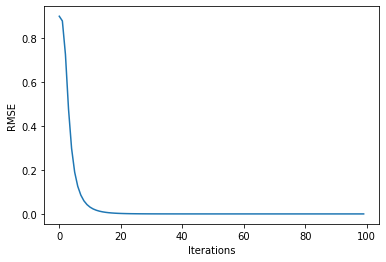

In [376]:

# plot the training error
plt.plot(range(num_iterations), training_errors)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show()

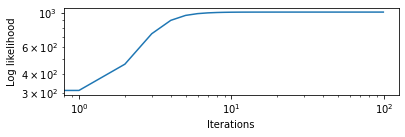

In [381]:
# plot the log likelihood error on a log scale
plt.plot(range(num_iterations), log_errors)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')
plt.yscale('log')
plt.xscale('log')
# scale the y-axis and x-axis to the same scale
plt.axis('scaled')
plt.show()

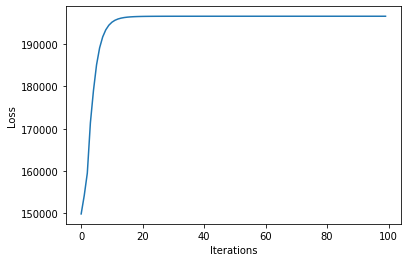

In [378]:
# plot the loss function
plt.plot(range(num_iterations), loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


In [379]:
item_factors

array([[ 1.03167261e-01,  2.41120688e-02,  8.96812915e-03, ...,
        -1.13216210e-01, -8.88769462e-02, -8.33083313e-02],
       [ 3.36555680e-03, -2.14113379e-03,  1.98747733e-01, ...,
         1.92566903e-02, -1.72027004e-04,  7.34866130e-02],
       [ 3.28877052e-02, -1.43853750e-01, -4.05279128e-02, ...,
        -4.37000985e-02,  5.85240660e-04, -2.72057101e-02],
       ...,
       [ 4.06806066e-02, -2.50792278e-03,  4.11515102e-02, ...,
         5.71912638e-03,  6.77213978e-02, -2.99278683e-02],
       [ 4.08900646e-02,  5.83833131e-02, -2.91951990e-03, ...,
        -1.05325573e-02, -2.44781222e-02, -1.99638454e-02],
       [-1.16484073e-03,  2.04313514e-02,  4.26586384e-02, ...,
         3.52949569e-03, -5.57631670e-04,  3.66934399e-02]])

In [380]:
user_factors

array([[ 0.1205135 , -0.0559484 ,  0.14060801, ...,  0.01773359,
        -0.04734345, -0.02993833],
       [-0.05760022,  0.05830345,  0.04925026, ..., -0.06122325,
         0.06298772, -0.01437018],
       [-0.08524189, -0.00497082,  0.0733969 , ...,  0.03017883,
         0.0543632 , -0.05941365],
       ...,
       [-0.05492759,  0.2310478 ,  0.0390435 , ..., -0.00657944,
        -0.05688859,  0.02717869],
       [ 0.02109573, -0.04760732, -0.00803413, ...,  0.00776641,
         0.01310154, -0.00043291],
       [ 0.06629545, -0.03248964,  0.01825141, ..., -0.01205907,
         0.0364659 , -0.00489294]])

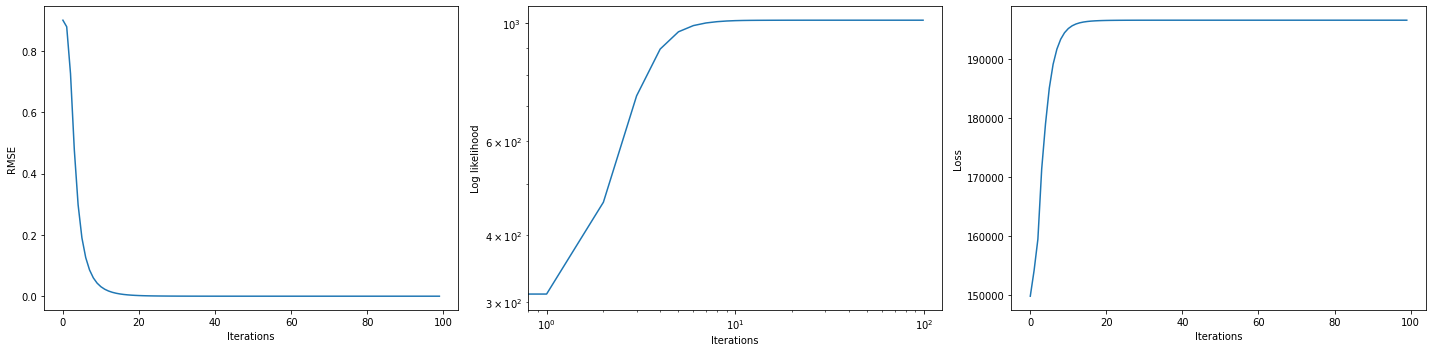

In [386]:
# create a subplot of 1 row and 3 columns
plt.figure(figsize=(20, 5))

# plot the RMSE
plt.subplot(1, 3, 1)
plt.plot(range(num_iterations), training_errors)
plt.xlabel('Iterations')
plt.ylabel('RMSE')

# plot the log likelihood
plt.subplot(1, 3, 2)
plt.plot(range(num_iterations), log_errors)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')
plt.yscale('log')
plt.xscale('log')

# plot the loss function
plt.subplot(1, 3, 3)
plt.plot(range(num_iterations), loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')

# adjust the subplots so that the plots don't overlap
plt.tight_layout()
plt.show()

In [390]:
# get predictions for a random user
user = 100
user_bias[user] + item_bias + user_factors[user, :].dot(item_factors.T)

# get the list of movies that the user has already watched
watched_movies = ratings_new[ratings_new['userId'] == user]['movieId'].tolist()

# use the movie_key dictionary to get the movie titles
watched_movies = [new_movieId[movie] for movie in watched_movies]

KeyError: 217

In [391]:
watched_movies

[1,
 2,
 217,
 308,
 3,
 309,
 310,
 346,
 347,
 348,
 9,
 349,
 592,
 813,
 354,
 356,
 11,
 12,
 362,
 363,
 311,
 313,
 371,
 373,
 15,
 375,
 180,
 378,
 315,
 18,
 381,
 19,
 316,
 387,
 317,
 816,
 389,
 390,
 392,
 393,
 23,
 319,
 24,
 25,
 232,
 28,
 29,
 495,
 233,
 322,
 30,
 31,
 32,
 412]

# Data Wrangling and Preprocessing

Before we can start building our movie recommender system, we need to perform some data wrangling and preprocessing on the MovieLens dataset. The dataset contains a large number of ratings and reviews for movies, and we need to extract the relevant features and organize the data in an optimised way that is suitable for training our model.

We will do this in the following steps:

1. Load the data
2. Extract the relevant features
3. Create two mappings: one for the movies and its index, and one for the users and their index (for the range of movies they have rated) as well as the ratings they have given.
4. Create a sparse matrix of the ratings
5. Split the data into training and test sets

#### Indexing Twice (as advised (hopfully?))

In [444]:
ratings_new.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'datetime', 'title',
       'genres', 'num_genres', 'avg_rating', 'num_ratings'],
      dtype='object')

In [445]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'datetime'], dtype='object')

In [446]:
reduced_movie_df.columns

Index(['index', 'movieId', 'title', 'genres', 'num_genres'], dtype='object')

In [447]:
movies.columns


Index(['movieId', 'title', 'genres', 'num_genres'], dtype='object')

In [448]:
# set ratings and movies to the new dataframes
ratings = ratings_new
movies = reduced_movie_df

In [449]:
ratings

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres,avg_rating,num_ratings
0,1,1,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
1,5,1,4.0,847434962,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
2,7,1,4.5,1106635946,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
3,15,1,2.5,1510577970,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
4,17,1,4.5,1305696483,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
...,...,...,...,...,...,...,...,...,...,...
58254,572,2013,1.0,945887535,1999-12-22 18:32:15,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18
58255,577,2013,3.0,945967440,1999-12-23 16:44:00,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18
58256,590,2013,2.5,1258420216,2009-11-17 01:10:16,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18
58257,597,2013,3.0,941640433,1999-11-03 14:47:13,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18


In [450]:
# create a list of tuples: for every unique userId store a list of tuples (movieId, rating)
ratings_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
# convert to tuple to make it hashable
ratings_list = [tuple(map(tuple, x)) for x in ratings_list]
# print the first list
ratings_list[0]

<ipython-input-450-2b26467b3a04>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ratings_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()


((1.0, 4.0),
 (3.0, 4.0),
 (6.0, 4.0),
 (47.0, 5.0),
 (50.0, 5.0),
 (70.0, 3.0),
 (101.0, 5.0),
 (110.0, 4.0),
 (151.0, 5.0),
 (163.0, 5.0),
 (216.0, 5.0),
 (223.0, 3.0),
 (231.0, 5.0),
 (235.0, 4.0),
 (260.0, 5.0),
 (296.0, 3.0),
 (316.0, 3.0),
 (333.0, 5.0),
 (349.0, 4.0),
 (356.0, 4.0),
 (362.0, 5.0),
 (367.0, 4.0),
 (441.0, 4.0),
 (457.0, 5.0),
 (480.0, 4.0),
 (500.0, 3.0),
 (527.0, 5.0),
 (543.0, 4.0),
 (552.0, 4.0),
 (553.0, 5.0),
 (590.0, 4.0),
 (592.0, 4.0),
 (593.0, 4.0),
 (596.0, 5.0),
 (608.0, 5.0),
 (648.0, 3.0),
 (661.0, 5.0),
 (673.0, 3.0),
 (733.0, 4.0),
 (736.0, 3.0),
 (780.0, 3.0),
 (919.0, 5.0),
 (923.0, 5.0),
 (1025.0, 5.0),
 (1029.0, 5.0),
 (1031.0, 5.0),
 (1032.0, 5.0),
 (1042.0, 4.0),
 (1049.0, 5.0),
 (1060.0, 4.0),
 (1073.0, 5.0),
 (1080.0, 5.0),
 (1089.0, 5.0),
 (1090.0, 4.0),
 (1092.0, 5.0),
 (1097.0, 5.0),
 (1127.0, 4.0),
 (1136.0, 5.0),
 (1196.0, 5.0),
 (1197.0, 5.0),
 (1198.0, 5.0),
 (1206.0, 5.0),
 (1208.0, 4.0),
 (1210.0, 5.0),
 (1213.0, 5.0),
 (1214.0, 4.

In [451]:
# create a dictionary of ratings: for every unique userId store a dictionary {movieId: rating}
ratings_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()
# print the first dictionary
ratings_dict[1]

<ipython-input-451-bedae8e70ad9>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ratings_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()


{1: 4.0,
 3: 4.0,
 6: 4.0,
 47: 5.0,
 50: 5.0,
 70: 3.0,
 101: 5.0,
 110: 4.0,
 151: 5.0,
 163: 5.0,
 216: 5.0,
 223: 3.0,
 231: 5.0,
 235: 4.0,
 260: 5.0,
 296: 3.0,
 316: 3.0,
 333: 5.0,
 349: 4.0,
 356: 4.0,
 362: 5.0,
 367: 4.0,
 441: 4.0,
 457: 5.0,
 480: 4.0,
 500: 3.0,
 527: 5.0,
 543: 4.0,
 552: 4.0,
 553: 5.0,
 590: 4.0,
 592: 4.0,
 593: 4.0,
 596: 5.0,
 608: 5.0,
 648: 3.0,
 661: 5.0,
 673: 3.0,
 733: 4.0,
 736: 3.0,
 780: 3.0,
 919: 5.0,
 923: 5.0,
 1025: 5.0,
 1029: 5.0,
 1031: 5.0,
 1032: 5.0,
 1042: 4.0,
 1049: 5.0,
 1060: 4.0,
 1073: 5.0,
 1080: 5.0,
 1089: 5.0,
 1090: 4.0,
 1092: 5.0,
 1097: 5.0,
 1127: 4.0,
 1136: 5.0,
 1196: 5.0,
 1197: 5.0,
 1198: 5.0,
 1206: 5.0,
 1208: 4.0,
 1210: 5.0,
 1213: 5.0,
 1214: 4.0,
 1219: 2.0,
 1220: 5.0,
 1222: 5.0,
 1240: 5.0,
 1256: 5.0,
 1258: 3.0,
 1265: 4.0,
 1270: 5.0,
 1275: 5.0,
 1278: 5.0,
 1282: 5.0,
 1291: 5.0,
 1298: 5.0,
 1377: 3.0,
 1396: 3.0,
 1408: 3.0,
 1500: 4.0,
 1517: 5.0,
 1552: 4.0,
 1573: 5.0,
 1580: 3.0,
 1587: 5

In [452]:
# create a list of tuples: for every movie_id what is the list of users that rated it (userId, rating)
movies_list = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
# convert to tuple to make it hashable
movies_list = [tuple(map(tuple, x)) for x in movies_list]
# print the first list
movies_list[0]

<ipython-input-452-f2df092249e3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  movies_list = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.values.tolist()).tolist()


((1.0, 4.0),
 (5.0, 4.0),
 (7.0, 4.5),
 (15.0, 2.5),
 (17.0, 4.5),
 (18.0, 3.5),
 (19.0, 4.0),
 (21.0, 3.5),
 (27.0, 3.0),
 (31.0, 5.0),
 (32.0, 3.0),
 (33.0, 3.0),
 (40.0, 5.0),
 (43.0, 5.0),
 (44.0, 3.0),
 (45.0, 4.0),
 (46.0, 5.0),
 (50.0, 3.0),
 (54.0, 3.0),
 (57.0, 5.0),
 (63.0, 5.0),
 (64.0, 4.0),
 (66.0, 4.0),
 (71.0, 5.0),
 (73.0, 4.5),
 (76.0, 0.5),
 (78.0, 4.0),
 (82.0, 2.5),
 (86.0, 4.0),
 (89.0, 3.0),
 (90.0, 3.0),
 (91.0, 4.0),
 (93.0, 3.0),
 (96.0, 5.0),
 (98.0, 4.5),
 (103.0, 4.0),
 (107.0, 4.0),
 (112.0, 3.0),
 (119.0, 3.5),
 (121.0, 4.0),
 (124.0, 4.0),
 (130.0, 3.0),
 (132.0, 2.0),
 (134.0, 3.0),
 (135.0, 4.0),
 (137.0, 4.0),
 (140.0, 3.0),
 (141.0, 4.0),
 (144.0, 3.5),
 (145.0, 5.0),
 (151.0, 5.0),
 (153.0, 2.0),
 (155.0, 3.0),
 (156.0, 4.0),
 (159.0, 4.5),
 (160.0, 4.0),
 (161.0, 4.0),
 (166.0, 5.0),
 (167.0, 3.5),
 (169.0, 4.5),
 (171.0, 5.0),
 (177.0, 5.0),
 (178.0, 4.0),
 (179.0, 4.0),
 (182.0, 4.0),
 (185.0, 4.0),
 (186.0, 4.0),
 (191.0, 4.0),
 (193.0, 2.0),
 (2

In [453]:
# create a dictionary of ratings: for every movie_id what is the dictionary of users that rated it {userId: rating}
movies_dict = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.set_index('userId')['rating'].to_dict()).to_dict()
# print the first dictionary
movies_dict[1]

<ipython-input-453-1e043b2c836e>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  movies_dict = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.set_index('userId')['rating'].to_dict()).to_dict()


{1: 4.0,
 5: 4.0,
 7: 4.5,
 15: 2.5,
 17: 4.5,
 18: 3.5,
 19: 4.0,
 21: 3.5,
 27: 3.0,
 31: 5.0,
 32: 3.0,
 33: 3.0,
 40: 5.0,
 43: 5.0,
 44: 3.0,
 45: 4.0,
 46: 5.0,
 50: 3.0,
 54: 3.0,
 57: 5.0,
 63: 5.0,
 64: 4.0,
 66: 4.0,
 71: 5.0,
 73: 4.5,
 76: 0.5,
 78: 4.0,
 82: 2.5,
 86: 4.0,
 89: 3.0,
 90: 3.0,
 91: 4.0,
 93: 3.0,
 96: 5.0,
 98: 4.5,
 103: 4.0,
 107: 4.0,
 112: 3.0,
 119: 3.5,
 121: 4.0,
 124: 4.0,
 130: 3.0,
 132: 2.0,
 134: 3.0,
 135: 4.0,
 137: 4.0,
 140: 3.0,
 141: 4.0,
 144: 3.5,
 145: 5.0,
 151: 5.0,
 153: 2.0,
 155: 3.0,
 156: 4.0,
 159: 4.5,
 160: 4.0,
 161: 4.0,
 166: 5.0,
 167: 3.5,
 169: 4.5,
 171: 5.0,
 177: 5.0,
 178: 4.0,
 179: 4.0,
 182: 4.0,
 185: 4.0,
 186: 4.0,
 191: 4.0,
 193: 2.0,
 200: 3.5,
 201: 5.0,
 202: 4.0,
 206: 5.0,
 213: 3.5,
 214: 3.0,
 216: 3.0,
 217: 4.0,
 219: 3.5,
 220: 5.0,
 223: 3.5,
 226: 3.5,
 229: 5.0,
 232: 3.5,
 233: 3.0,
 234: 5.0,
 239: 4.0,
 240: 5.0,
 247: 5.0,
 252: 4.5,
 254: 4.5,
 263: 4.0,
 264: 4.0,
 266: 2.0,
 269: 5.0,
 270

In [454]:
movies

,index,movieId,title,genres,num_genres
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,3
2,2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,5,Father of the Bride Part II (1995),Comedy,1
4,5,6,Heat (1995),Action|Crime|Thriller,3
...,...,...,...,...,...
1230,9162,148626,"Big Short, The (2015)",Drama,1
1231,9223,152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy,5
1232,9392,164179,Arrival (2016),Sci-Fi,1
1233,9433,166528,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,4


In [455]:
# create a dictionary that maps the movieId to the movie title
movieId_to_title = movies.set_index('movieId')['title'].to_dict()
# print the first 10 items
len(list(movieId_to_title.items()))

1235

In [456]:
movies['movieId'].nunique()

1235

In [496]:
# create a list of tuples: for every user_id what is the list of movies they've watched and ratings: (movie_id, rating)
users_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
# convert to tuple to make it hashable
users_list = [tuple(map(tuple, x)) for x in users_list]
# print the first list
users_list[0]

<ipython-input-496-329b15558ab7>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  users_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()


((1.0, 4.0),
 (3.0, 4.0),
 (6.0, 4.0),
 (47.0, 5.0),
 (50.0, 5.0),
 (70.0, 3.0),
 (101.0, 5.0),
 (110.0, 4.0),
 (151.0, 5.0),
 (163.0, 5.0),
 (216.0, 5.0),
 (223.0, 3.0),
 (231.0, 5.0),
 (235.0, 4.0),
 (260.0, 5.0),
 (296.0, 3.0),
 (316.0, 3.0),
 (333.0, 5.0),
 (349.0, 4.0),
 (356.0, 4.0),
 (362.0, 5.0),
 (367.0, 4.0),
 (441.0, 4.0),
 (457.0, 5.0),
 (480.0, 4.0),
 (500.0, 3.0),
 (527.0, 5.0),
 (543.0, 4.0),
 (552.0, 4.0),
 (553.0, 5.0),
 (590.0, 4.0),
 (592.0, 4.0),
 (593.0, 4.0),
 (596.0, 5.0),
 (608.0, 5.0),
 (648.0, 3.0),
 (661.0, 5.0),
 (673.0, 3.0),
 (733.0, 4.0),
 (736.0, 3.0),
 (780.0, 3.0),
 (919.0, 5.0),
 (923.0, 5.0),
 (1025.0, 5.0),
 (1029.0, 5.0),
 (1031.0, 5.0),
 (1032.0, 5.0),
 (1042.0, 4.0),
 (1049.0, 5.0),
 (1060.0, 4.0),
 (1073.0, 5.0),
 (1080.0, 5.0),
 (1089.0, 5.0),
 (1090.0, 4.0),
 (1092.0, 5.0),
 (1097.0, 5.0),
 (1127.0, 4.0),
 (1136.0, 5.0),
 (1196.0, 5.0),
 (1197.0, 5.0),
 (1198.0, 5.0),
 (1206.0, 5.0),
 (1208.0, 4.0),
 (1210.0, 5.0),
 (1213.0, 5.0),
 (1214.0, 4.

In [497]:
# create a dictionary of ratings: for every user_id what is the dictionary of movies they've watched and ratings: {movie_id: rating}
users_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()
# print the first dictionary
users_dict[1]

<ipython-input-497-526929765520>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  users_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()


{1: 4.0,
 3: 4.0,
 6: 4.0,
 47: 5.0,
 50: 5.0,
 70: 3.0,
 101: 5.0,
 110: 4.0,
 151: 5.0,
 163: 5.0,
 216: 5.0,
 223: 3.0,
 231: 5.0,
 235: 4.0,
 260: 5.0,
 296: 3.0,
 316: 3.0,
 333: 5.0,
 349: 4.0,
 356: 4.0,
 362: 5.0,
 367: 4.0,
 441: 4.0,
 457: 5.0,
 480: 4.0,
 500: 3.0,
 527: 5.0,
 543: 4.0,
 552: 4.0,
 553: 5.0,
 590: 4.0,
 592: 4.0,
 593: 4.0,
 596: 5.0,
 608: 5.0,
 648: 3.0,
 661: 5.0,
 673: 3.0,
 733: 4.0,
 736: 3.0,
 780: 3.0,
 919: 5.0,
 923: 5.0,
 1025: 5.0,
 1029: 5.0,
 1031: 5.0,
 1032: 5.0,
 1042: 4.0,
 1049: 5.0,
 1060: 4.0,
 1073: 5.0,
 1080: 5.0,
 1089: 5.0,
 1090: 4.0,
 1092: 5.0,
 1097: 5.0,
 1127: 4.0,
 1136: 5.0,
 1196: 5.0,
 1197: 5.0,
 1198: 5.0,
 1206: 5.0,
 1208: 4.0,
 1210: 5.0,
 1213: 5.0,
 1214: 4.0,
 1219: 2.0,
 1220: 5.0,
 1222: 5.0,
 1240: 5.0,
 1256: 5.0,
 1258: 3.0,
 1265: 4.0,
 1270: 5.0,
 1275: 5.0,
 1278: 5.0,
 1282: 5.0,
 1291: 5.0,
 1298: 5.0,
 1377: 3.0,
 1396: 3.0,
 1408: 3.0,
 1500: 4.0,
 1517: 5.0,
 1552: 4.0,
 1573: 5.0,
 1580: 3.0,
 1587: 5

In [457]:
# indexing: create a list that maps the movieId to a new index (0, 1, 2, ...)
movieId_to_index = {movieId: i for i, movieId in enumerate(movies['movieId'].unique())}

# indexing: create a list that maps the new index to the movieId (0 -> movieId, 1 -> movieId, 2 -> movieId, ...)
index_to_movieId = {i: movieId for movieId, i in movieId_to_index.items()}

In [458]:
movieId_to_index

{1: 0,
 2: 1,
 3: 2,
 5: 3,
 6: 4,
 7: 5,
 10: 6,
 11: 7,
 16: 8,
 17: 9,
 19: 10,
 21: 11,
 22: 12,
 24: 13,
 25: 14,
 29: 15,
 31: 16,
 32: 17,
 34: 18,
 36: 19,
 39: 20,
 44: 21,
 45: 22,
 47: 23,
 48: 24,
 50: 25,
 52: 26,
 58: 27,
 60: 28,
 62: 29,
 65: 30,
 70: 31,
 95: 32,
 101: 33,
 104: 34,
 105: 35,
 107: 36,
 110: 37,
 111: 38,
 112: 39,
 135: 40,
 141: 41,
 145: 42,
 150: 43,
 151: 44,
 153: 45,
 158: 46,
 160: 47,
 161: 48,
 163: 49,
 165: 50,
 168: 51,
 170: 52,
 172: 53,
 173: 54,
 180: 55,
 185: 56,
 186: 57,
 193: 58,
 196: 59,
 198: 60,
 203: 61,
 204: 62,
 207: 63,
 208: 64,
 215: 65,
 216: 66,
 223: 67,
 224: 68,
 225: 69,
 227: 70,
 230: 71,
 231: 72,
 235: 73,
 236: 74,
 237: 75,
 246: 76,
 247: 77,
 252: 78,
 253: 79,
 256: 80,
 260: 81,
 261: 82,
 262: 83,
 265: 84,
 266: 85,
 272: 86,
 273: 87,
 276: 88,
 277: 89,
 282: 90,
 288: 91,
 292: 92,
 293: 93,
 296: 94,
 300: 95,
 303: 96,
 307: 97,
 315: 98,
 316: 99,
 317: 100,
 318: 101,
 327: 102,
 329: 103,
 333:

In [459]:
index_to_movieId

{0: 1,
 1: 2,
 2: 3,
 3: 5,
 4: 6,
 5: 7,
 6: 10,
 7: 11,
 8: 16,
 9: 17,
 10: 19,
 11: 21,
 12: 22,
 13: 24,
 14: 25,
 15: 29,
 16: 31,
 17: 32,
 18: 34,
 19: 36,
 20: 39,
 21: 44,
 22: 45,
 23: 47,
 24: 48,
 25: 50,
 26: 52,
 27: 58,
 28: 60,
 29: 62,
 30: 65,
 31: 70,
 32: 95,
 33: 101,
 34: 104,
 35: 105,
 36: 107,
 37: 110,
 38: 111,
 39: 112,
 40: 135,
 41: 141,
 42: 145,
 43: 150,
 44: 151,
 45: 153,
 46: 158,
 47: 160,
 48: 161,
 49: 163,
 50: 165,
 51: 168,
 52: 170,
 53: 172,
 54: 173,
 55: 180,
 56: 185,
 57: 186,
 58: 193,
 59: 196,
 60: 198,
 61: 203,
 62: 204,
 63: 207,
 64: 208,
 65: 215,
 66: 216,
 67: 223,
 68: 224,
 69: 225,
 70: 227,
 71: 230,
 72: 231,
 73: 235,
 74: 236,
 75: 237,
 76: 246,
 77: 247,
 78: 252,
 79: 253,
 80: 256,
 81: 260,
 82: 261,
 83: 262,
 84: 265,
 85: 266,
 86: 272,
 87: 273,
 88: 276,
 89: 277,
 90: 282,
 91: 288,
 92: 292,
 93: 293,
 94: 296,
 95: 300,
 96: 303,
 97: 307,
 98: 315,
 99: 316,
 100: 317,
 101: 318,
 102: 327,
 103: 329,
 104:

In [460]:
# similary for the userId (0, 1, 2, ...)
userId_to_index = {userId: i for i, userId in enumerate(ratings['userId'].unique())}
index_to_userId = {i: userId for userId, i in userId_to_index.items()}

In [461]:
userId_to_index

{1: 0,
 5: 1,
 7: 2,
 15: 3,
 17: 4,
 18: 5,
 19: 6,
 21: 7,
 27: 8,
 31: 9,
 32: 10,
 33: 11,
 40: 12,
 43: 13,
 44: 14,
 45: 15,
 46: 16,
 50: 17,
 54: 18,
 57: 19,
 63: 20,
 64: 21,
 66: 22,
 71: 23,
 73: 24,
 76: 25,
 78: 26,
 82: 27,
 86: 28,
 89: 29,
 90: 30,
 91: 31,
 93: 32,
 96: 33,
 98: 34,
 103: 35,
 107: 36,
 112: 37,
 119: 38,
 121: 39,
 124: 40,
 130: 41,
 132: 42,
 134: 43,
 135: 44,
 137: 45,
 140: 46,
 141: 47,
 144: 48,
 145: 49,
 151: 50,
 153: 51,
 155: 52,
 156: 53,
 159: 54,
 160: 55,
 161: 56,
 166: 57,
 167: 58,
 169: 59,
 171: 60,
 177: 61,
 178: 62,
 179: 63,
 182: 64,
 185: 65,
 186: 66,
 191: 67,
 193: 68,
 200: 69,
 201: 70,
 202: 71,
 206: 72,
 213: 73,
 214: 74,
 216: 75,
 217: 76,
 219: 77,
 220: 78,
 223: 79,
 226: 80,
 229: 81,
 232: 82,
 233: 83,
 234: 84,
 239: 85,
 240: 86,
 247: 87,
 252: 88,
 254: 89,
 263: 90,
 264: 91,
 266: 92,
 269: 93,
 270: 94,
 273: 95,
 275: 96,
 276: 97,
 277: 98,
 279: 99,
 280: 100,
 282: 101,
 283: 102,
 290: 103,
 291

In [462]:
index_to_userId

{0: 1,
 1: 5,
 2: 7,
 3: 15,
 4: 17,
 5: 18,
 6: 19,
 7: 21,
 8: 27,
 9: 31,
 10: 32,
 11: 33,
 12: 40,
 13: 43,
 14: 44,
 15: 45,
 16: 46,
 17: 50,
 18: 54,
 19: 57,
 20: 63,
 21: 64,
 22: 66,
 23: 71,
 24: 73,
 25: 76,
 26: 78,
 27: 82,
 28: 86,
 29: 89,
 30: 90,
 31: 91,
 32: 93,
 33: 96,
 34: 98,
 35: 103,
 36: 107,
 37: 112,
 38: 119,
 39: 121,
 40: 124,
 41: 130,
 42: 132,
 43: 134,
 44: 135,
 45: 137,
 46: 140,
 47: 141,
 48: 144,
 49: 145,
 50: 151,
 51: 153,
 52: 155,
 53: 156,
 54: 159,
 55: 160,
 56: 161,
 57: 166,
 58: 167,
 59: 169,
 60: 171,
 61: 177,
 62: 178,
 63: 179,
 64: 182,
 65: 185,
 66: 186,
 67: 191,
 68: 193,
 69: 200,
 70: 201,
 71: 202,
 72: 206,
 73: 213,
 74: 214,
 75: 216,
 76: 217,
 77: 219,
 78: 220,
 79: 223,
 80: 226,
 81: 229,
 82: 232,
 83: 233,
 84: 234,
 85: 239,
 86: 240,
 87: 247,
 88: 252,
 89: 254,
 90: 263,
 91: 264,
 92: 266,
 93: 269,
 94: 270,
 95: 273,
 96: 275,
 97: 276,
 98: 277,
 99: 279,
 100: 280,
 101: 282,
 102: 283,
 103: 290,
 104

### Some refactoring of the indexing above:

In [463]:
ratings

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres,avg_rating,num_ratings
0,1,1,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
1,5,1,4.0,847434962,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
2,7,1,4.5,1106635946,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
3,15,1,2.5,1510577970,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
4,17,1,4.5,1305696483,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204
...,...,...,...,...,...,...,...,...,...,...
58254,572,2013,1.0,945887535,1999-12-22 18:32:15,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18
58255,577,2013,3.0,945967440,1999-12-23 16:44:00,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18
58256,590,2013,2.5,1258420216,2009-11-17 01:10:16,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18
58257,597,2013,3.0,941640433,1999-11-03 14:47:13,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18


In [464]:
# map the userId to the new index
ratings['reset_userId'] = ratings['userId'].map(userId_to_index)

In [465]:
ratings

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres,avg_rating,num_ratings,reset_userId
0,1,1,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,0
1,5,1,4.0,847434962,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,1
2,7,1,4.5,1106635946,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,2
3,15,1,2.5,1510577970,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,3
4,17,1,4.5,1305696483,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,4
...,...,...,...,...,...,...,...,...,...,...,...
58254,572,2013,1.0,945887535,1999-12-22 18:32:15,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18,187
58255,577,2013,3.0,945967440,1999-12-23 16:44:00,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18,256
58256,590,2013,2.5,1258420216,2009-11-17 01:10:16,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18,193
58257,597,2013,3.0,941640433,1999-11-03 14:47:13,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18,195


In [466]:
# map the movieId to the new index
ratings['reset_movieId'] = ratings['movieId'].map(movieId_to_index)

In [467]:
ratings

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres,avg_rating,num_ratings,reset_userId,reset_movieId
0,1,1,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,0,0
1,5,1,4.0,847434962,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,1,0
2,7,1,4.5,1106635946,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,2,0
3,15,1,2.5,1510577970,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,3,0
4,17,1,4.5,1305696483,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,3.919118,204,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58254,572,2013,1.0,945887535,1999-12-22 18:32:15,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18,187,486
58255,577,2013,3.0,945967440,1999-12-23 16:44:00,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18,256,486
58256,590,2013,2.5,1258420216,2009-11-17 01:10:16,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18,193,486
58257,597,2013,3.0,941640433,1999-11-03 14:47:13,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3,2.972222,18,195,486


In [468]:
# create a list of tuples: for every unique userId store a list of tuples (movieId, rating)
user_ratings_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
# convert to tuple to make it hashable
user_ratings_list = [tuple(map(tuple, x)) for x in user_ratings_list]

# create a dictionary of ratings: for every unique userId store a dictionary {movieId: rating}
user_ratings_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()

# create a dictionary of user index and a list of movies they watched in a range
user_indexer = {}
user_range_index = []
movie_rating_list = []
start = 0
for user_id, user_ratings in enumerate(user_ratings_list):
    user_indexer[user_id] = []
    for movie_id, rating in user_ratings:
        movie_index = movieId_to_index[movie_id]
        user_indexer[user_id].append((movie_index, rating))
        movie_rating_tuple = (movie_index, rating)
        movie_rating_list.append(movie_rating_tuple)
    user_range_index.append((start, start + len(user_ratings)))
    start += len(user_ratings)

# create a list of users
users = list(range(len(user_ratings_list)))


<ipython-input-468-34146d4667f0>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_ratings_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
<ipython-input-468-34146d4667f0>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_ratings_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()


In [469]:
# create a list of tuples: for every movie_id what is the list of users that rated it (userId, rating)
movie_ratings_list = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
# convert to tuple to make it hashable
movie_ratings_list = [tuple(map(tuple, x)) for x in movie_ratings_list]

# create a dictionary of ratings: for every movie_id what is the dictionary of users that rated it {userId: rating}
movie_ratings_dict = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.set_index('userId')['rating'].to_dict()).to_dict()

# create a dictionary of movie index and a list of users who watched it
movie_indexer = {}
for movie_id, movie_ratings in movie_ratings_dict.items():
    movie_index = movieId_to_index[movie_id]
    movie_indexer[movie_index] = []
    for user_id, rating in movie_ratings.items():
        user_index = userId_to_index[user_id]
        movie_indexer[movie_index].append((user_index, rating))

# create a list of movies
movie_items = list(range(len(movie_ratings_list)))


<ipython-input-469-4ee94c7b35a2>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  movie_ratings_list = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
<ipython-input-469-4ee94c7b35a2>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  movie_ratings_dict = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.set_index('userId')['rating'].to_dict()).to_dict()


In [472]:
movie_items

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [477]:
movie_indexer[1]

[(204, 4.0),
 (260, 4.0),
 (5, 3.0),
 (6, 3.0),
 (513, 3.0),
 (7, 3.5),
 (8, 4.0),
 (206, 4.5),
 (228, 4.0),
 (27, 3.0),
 (31, 3.0),
 (32, 5.0),
 (272, 4.0),
 (35, 4.0),
 (273, 3.0),
 (36, 5.0),
 (37, 1.5),
 (211, 3.0),
 (275, 4.0),
 (390, 4.0),
 (44, 3.0),
 (46, 3.5),
 (48, 3.0),
 (459, 1.0),
 (51, 2.0),
 (55, 4.0),
 (59, 4.0),
 (61, 3.5),
 (66, 4.0),
 (71, 4.0),
 (76, 2.0),
 (77, 2.5),
 (345, 3.5),
 (289, 2.5),
 (80, 3.0),
 (291, 2.5),
 (82, 4.0),
 (86, 5.0),
 (559, 2.0),
 (97, 4.0),
 (298, 4.0),
 (214, 3.0),
 (107, 0.5),
 (551, 3.0),
 (108, 4.0),
 (239, 3.5),
 (109, 2.5),
 (216, 3.0),
 (243, 3.5),
 (217, 5.0),
 (111, 3.0),
 (112, 4.0),
 (114, 1.5),
 (121, 3.0),
 (123, 4.0),
 (124, 3.0),
 (125, 3.5),
 (129, 3.0),
 (131, 4.0),
 (411, 3.0),
 (139, 4.0),
 (248, 3.0),
 (315, 4.5),
 (143, 4.0),
 (144, 2.5),
 (145, 4.0),
 (319, 3.0),
 (415, 5.0),
 (417, 4.0),
 (155, 3.0),
 (474, 4.5),
 (157, 4.0),
 (158, 4.0),
 (159, 3.0),
 (369, 4.5),
 (160, 4.0),
 (161, 2.5),
 (322, 2.5),
 (371, 2.5),
 (

In [473]:
len(movie_indexer[0])

204

In [478]:
len(movie_items)

1235

In [479]:
len(user_ratings_list[0])

180

In [480]:
user_range_index[0:3]

[(0, 180), (180, 203), (203, 225)]

In [481]:
users

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [482]:
movie_rating_list[user_range_index[0][0]:user_range_index[0][1]]

[(0, 4.0),
 (2, 4.0),
 (4, 4.0),
 (23, 5.0),
 (25, 5.0),
 (31, 3.0),
 (33, 5.0),
 (37, 4.0),
 (44, 5.0),
 (49, 5.0),
 (66, 5.0),
 (67, 3.0),
 (72, 5.0),
 (73, 4.0),
 (81, 5.0),
 (94, 3.0),
 (99, 3.0),
 (104, 5.0),
 (111, 4.0),
 (115, 4.0),
 (117, 5.0),
 (119, 4.0),
 (138, 4.0),
 (142, 5.0),
 (148, 4.0),
 (152, 3.0),
 (159, 5.0),
 (164, 4.0),
 (167, 4.0),
 (168, 5.0),
 (176, 4.0),
 (177, 4.0),
 (178, 4.0),
 (181, 5.0),
 (183, 5.0),
 (189, 3.0),
 (191, 5.0),
 (193, 3.0),
 (199, 4.0),
 (200, 3.0),
 (208, 3.0),
 (239, 5.0),
 (242, 5.0),
 (252, 5.0),
 (255, 5.0),
 (256, 5.0),
 (257, 5.0),
 (261, 4.0),
 (263, 5.0),
 (265, 4.0),
 (267, 5.0),
 (270, 5.0),
 (274, 5.0),
 (275, 4.0),
 (277, 5.0),
 (280, 5.0),
 (284, 4.0),
 (286, 5.0),
 (295, 5.0),
 (296, 5.0),
 (297, 5.0),
 (303, 5.0),
 (305, 4.0),
 (306, 5.0),
 (308, 5.0),
 (309, 4.0),
 (311, 2.0),
 (312, 5.0),
 (314, 5.0),
 (323, 5.0),
 (332, 5.0),
 (334, 3.0),
 (339, 4.0),
 (343, 5.0),
 (347, 5.0),
 (349, 5.0),
 (350, 5.0),
 (354, 5.0),
 (356,

In [483]:
len(movie_rating_list[user_range_index[0][0]:user_range_index[0][1]])

180

In [484]:
# create a list that uses the tuple in the user_range_index to populate the list with movies corresponding to the index in user_ratings_list
user_movie_list = []
for start, end in user_range_index:
    user_movie_list.append(movie_rating_list[start:end])

In [485]:
# create a list that uses the the tuple in the movie_indexer to populate the list with users and their ratings corresponding to the index in movie_ratings_list
movie_user_list = []
for movie_index in movie_items:
    movie_user_list.append(movie_indexer[movie_index])


In [488]:
movie_user_list[0]

[(0, 4.0),
 (1, 4.0),
 (2, 4.5),
 (3, 2.5),
 (4, 4.5),
 (5, 3.5),
 (6, 4.0),
 (7, 3.5),
 (8, 3.0),
 (9, 5.0),
 (10, 3.0),
 (11, 3.0),
 (12, 5.0),
 (13, 5.0),
 (14, 3.0),
 (15, 4.0),
 (16, 5.0),
 (17, 3.0),
 (18, 3.0),
 (19, 5.0),
 (20, 5.0),
 (21, 4.0),
 (22, 4.0),
 (23, 5.0),
 (24, 4.5),
 (25, 0.5),
 (26, 4.0),
 (27, 2.5),
 (28, 4.0),
 (29, 3.0),
 (30, 3.0),
 (31, 4.0),
 (32, 3.0),
 (33, 5.0),
 (34, 4.5),
 (35, 4.0),
 (36, 4.0),
 (37, 3.0),
 (38, 3.5),
 (39, 4.0),
 (40, 4.0),
 (41, 3.0),
 (42, 2.0),
 (43, 3.0),
 (44, 4.0),
 (45, 4.0),
 (46, 3.0),
 (47, 4.0),
 (48, 3.5),
 (49, 5.0),
 (50, 5.0),
 (51, 2.0),
 (52, 3.0),
 (53, 4.0),
 (54, 4.5),
 (55, 4.0),
 (56, 4.0),
 (57, 5.0),
 (58, 3.5),
 (59, 4.5),
 (60, 5.0),
 (61, 5.0),
 (62, 4.0),
 (63, 4.0),
 (64, 4.0),
 (65, 4.0),
 (66, 4.0),
 (67, 4.0),
 (68, 2.0),
 (69, 3.5),
 (70, 5.0),
 (71, 4.0),
 (72, 5.0),
 (73, 3.5),
 (74, 3.0),
 (75, 3.0),
 (76, 4.0),
 (77, 3.5),
 (78, 5.0),
 (79, 3.5),
 (80, 3.5),
 (81, 5.0),
 (82, 3.5),
 (83, 3.0),
 (

In [489]:
user_movie_list[2]

[(159, 0.5),
 (347, 3.5),
 (413, 4.5),
 (487, 0.5),
 (509, 2.0),
 (749, 5.0),
 (16, 0.5),
 (188, 0.5),
 (197, 0.5),
 (221, 5.0),
 (236, 0.5),
 (278, 0.5),
 (338, 0.5),
 (345, 0.5),
 (358, 0.5),
 (374, 3.0),
 (501, 0.5),
 (537, 4.0),
 (574, 0.5),
 (690, 0.5),
 (773, 0.5),
 (1126, 0.5)]

In [490]:
user_movie_list[0]
len(user_movie_list[0])

180

In [491]:
len(user_movie_list)

584

In [492]:
user_movie_list

[[(0, 4.0),
  (2, 4.0),
  (4, 4.0),
  (23, 5.0),
  (25, 5.0),
  (31, 3.0),
  (33, 5.0),
  (37, 4.0),
  (44, 5.0),
  (49, 5.0),
  (66, 5.0),
  (67, 3.0),
  (72, 5.0),
  (73, 4.0),
  (81, 5.0),
  (94, 3.0),
  (99, 3.0),
  (104, 5.0),
  (111, 4.0),
  (115, 4.0),
  (117, 5.0),
  (119, 4.0),
  (138, 4.0),
  (142, 5.0),
  (148, 4.0),
  (152, 3.0),
  (159, 5.0),
  (164, 4.0),
  (167, 4.0),
  (168, 5.0),
  (176, 4.0),
  (177, 4.0),
  (178, 4.0),
  (181, 5.0),
  (183, 5.0),
  (189, 3.0),
  (191, 5.0),
  (193, 3.0),
  (199, 4.0),
  (200, 3.0),
  (208, 3.0),
  (239, 5.0),
  (242, 5.0),
  (252, 5.0),
  (255, 5.0),
  (256, 5.0),
  (257, 5.0),
  (261, 4.0),
  (263, 5.0),
  (265, 4.0),
  (267, 5.0),
  (270, 5.0),
  (274, 5.0),
  (275, 4.0),
  (277, 5.0),
  (280, 5.0),
  (284, 4.0),
  (286, 5.0),
  (295, 5.0),
  (296, 5.0),
  (297, 5.0),
  (303, 5.0),
  (305, 4.0),
  (306, 5.0),
  (308, 5.0),
  (309, 4.0),
  (311, 2.0),
  (312, 5.0),
  (314, 5.0),
  (323, 5.0),
  (332, 5.0),
  (334, 3.0),
  (339, 4.0)

### Iterative Alternating Least Squares Implementation

In [493]:

# Hyperparameters
num_factors = 10
lambda_value = 0.01
num_iterations = 20
items = movies['movieId'].nunique()

# Initialize biases
user_bias = np.zeros(len(users))
item_bias = np.zeros(items)

# Initialize factor matrices
user_factors = np.random.normal(size=(len(users), num_factors))
item_factors = np.random.normal(size=(items, num_factors))

Iteration 1: RMSE = 1.0106
Iteration 1: Loss = 60143.1881
Iteration 2: RMSE = 1.0324
Iteration 2: Loss = 62734.6331
Iteration 3: RMSE = 1.0144
Iteration 3: Loss = 60588.6828
Iteration 4: RMSE = 1.0329
Iteration 4: Loss = 62816.7301
Iteration 5: RMSE = 1.0337
Iteration 5: Loss = 62944.6536
Iteration 6: RMSE = 1.0254
Iteration 6: Loss = 61940.1280
Iteration 7: RMSE = 1.0293
Iteration 7: Loss = 62410.3752
Iteration 8: RMSE = 1.0217
Iteration 8: Loss = 61505.5890
Iteration 9: RMSE = 1.0315
Iteration 9: Loss = 62699.0358
Iteration 10: RMSE = 1.0357
Iteration 10: Loss = 63203.6967
Iteration 11: RMSE = 1.0347
Iteration 11: Loss = 63105.3700
Iteration 12: RMSE = 1.0507
Iteration 12: Loss = 65010.5367
Iteration 13: RMSE = 1.0570
Iteration 13: Loss = 65796.9031
Iteration 14: RMSE = 1.0419
Iteration 14: Loss = 63923.6893
Iteration 15: RMSE = 1.0468
Iteration 15: Loss = 64524.5558
Iteration 16: RMSE = 1.0366
Iteration 16: Loss = 63294.3977
Iteration 17: RMSE = 1.0328
Iteration 17: Loss = 62866.659

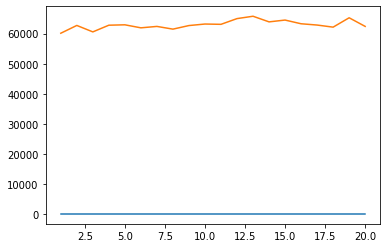

In [500]:
# Loop through iterations
rmse_list = []
loss_list = []
for i in range(num_iterations):
    # Update user biases
    for m in range(len(users)):
        bias_sum = 0
        for (n, r) in user_movie_list[m]:
            bias_sum += r - item_bias[n] - np.dot(user_factors[m], item_factors[n])
        user_bias[m] = bias_sum / (lambda_value + len(user_movie_list[m]))

    # Update item biases - 
    for n in range(items):
        bias_sum = 0
        for (m, r) in movie_user_list[n]:
            bias_sum += r - user_bias[m] - np.dot(user_factors[m], item_factors[n])
        item_bias[n] = bias_sum / (lambda_value + len(movie_user_list[n]))

    # Update factor matrices
    for m in range(len(users)):
        user_matrix = np.zeros((num_factors, num_factors))
        user_vector = np.zeros(num_factors)
        for (n, r) in user_movie_list[m]:
            user_matrix += np.outer(item_factors[n], item_factors[n])
            user_vector += (r - user_bias[m] - item_bias[n]) * item_factors[n]
        user_factors[m] = np.linalg.solve(user_matrix + lambda_value * np.eye(num_factors), user_vector)

    for n in range(items):
        item_matrix = np.zeros((num_factors, num_factors))
        item_vector = np.zeros(num_factors)
        for (m, r) in movie_user_list[n]:
            item_matrix += np.outer(user_factors[m], user_factors[m])
            item_vector += (r - user_bias[m] - item_bias[n]) * user_factors[m]
        item_factors[n] = np.linalg.solve(item_matrix + lambda_value * np.eye(num_factors), item_vector)
    
    # Calculate RMSE
    rmse = 0
    for m in range(len(users)):
        for (n, r) in user_movie_list[m]:
            rmse += (r - user_bias[m] - item_bias[n] - np.dot(user_factors[m], item_factors[n])) ** 2
    rmse = np.sqrt(rmse / len(ratings))
    rmse_list.append(rmse)
    print('Iteration %d: RMSE = %.4f' % (i + 1, rmse))

    # Calculate loss
    loss = 0
    for m in range(len(users)):
        for (n, r) in user_movie_list[m]:
            loss += (r - user_bias[m] - item_bias[n] - np.dot(user_factors[m], item_factors[n])) ** 2
        loss += lambda_value * (np.linalg.norm(user_factors[m]) ** 2 + np.linalg.norm(item_factors[n]) ** 2)
    loss_list.append(loss)
    print('Iteration %d: Loss = %.4f' % (i + 1, loss))

# plot the RMSE and loss
plt.plot(range(1, num_iterations + 1), rmse_list)

# plot the log liklihood of the loss function
plt.plot(range(1, num_iterations + 1), loss_list)


In [280]:
user_bias

array([ 4.84058492,  3.72301448,  1.01306906,  4.08280492,  4.54122169,
        3.85180124,  5.44399157,  3.18137645,  3.27282757,  2.45226029,
        5.74931742,  9.93725574,  4.26530989,  3.71615195,  3.5523827 ,
        3.48140252,  4.55399813,  4.20834232,  4.2890299 ,  4.34190162,
        3.77061595,  0.8804154 ,  3.31863266,  4.01297015,  4.54733172,
        3.07130989,  2.82090778,  3.37779391,  4.27529703,  4.89129526,
        3.61862584,  4.50462719,  4.73924417,  2.82236984,  5.2951224 ,
        3.18020714,  6.33440396,  3.89852367,  3.88652536,  4.49295661,
        3.17799191,  4.56943603,  6.08447192,  3.5598908 ,  4.67156308,
        3.94545063,  2.68171669,  4.72156301,  4.78382246,  3.23418016,
        4.73787294,  5.10521206,  2.57800042,  0.66687244,  4.11779566,
        3.87795286,  5.18543593,  4.85741402,  3.7522326 ,  4.08605781,
        4.57933124,  3.47441159,  3.70567014,  4.23755225,  4.51541504,
        3.38102751,  4.63531592,  4.48452007,  3.6445065 ,  4.39

In [283]:
len(item_bias)

1235

In [293]:
item_bias

array([-1.93866657, -2.32940858, -2.62747769, ..., -1.77707502,
       -1.90443953, -1.50209681])

# Alternating Least Squares

In [139]:
import numpy as np

class ALS:
    """
    Alternating Least Squares (ALS) matrix factorization model for recommendation system.

    Parameters
    ----------
    users : list
        List of unique user IDs.
    movies : list
        List of unique movie IDs.
    user_ratings : dict
        Dictionary containing the ratings given by each user.
        The keys are user IDs and the values are lists of tuples (movie_id, rating).
    user_range_index : dict
        Dictionary containing the index range for each user in the concatenated user feature vector.
        The keys are user IDs and the values are tuples (start_index, end_index).
    movie_ratings : dict
        Dictionary containing the ratings received by each movie.
        The keys are movie IDs and the values are lists of tuples (user_id, rating).
    k : int, optional
        Number of latent factors for the user and movie feature vectors. Default is 10.
    alpha : float, optional
        Learning rate for gradient descent. Default is 0.01.
    iterations : int, optional
        Number of iterations for ALS. Default is 10.
    """

    def __init__(self, users, movies, user_ratings, user_range_index, movie_ratings, k=10, alpha=0.01, iterations=10):
        self.users = users
        self.movies = movies
        self.user_ratings = user_ratings
        self.user_range_index = user_range_index
        self.movie_ratings = movie_ratings
        self.k = k
        self.alpha = alpha
        self.iterations = iterations

        # Initialize the user and movie feature vectors with random values
        self.user_features = np.random.rand(len(users), k)
        self.movie_features = np.random.rand(len(movies), k)

        # Initialize the user and movie biases and the global bias with random values
        self.user_biases = np.random.rand(len(users))
        self.movie_biases = np.random.rand(len(movies))
        self.global_bias = np.random.rand(1)

    def train(self):
        """
        Train the ALS model using Alternating Least Squares algorithm.
        """

        for i in range(self.iterations):
            print('Iteration: {}'.format(i))
            self.user_features = self.gradient_descent_user()
            self.movie_features = self.gradient_descent_movie()
            self.user_biases = self.gradient_descent_user_bias()
            self.movie_biases = self.gradient_descent_movie_bias()
            self.global_bias = self.gradient_descent_global_bias()

    def predict(self, user, movie):
        """
        Predict the rating for a user and a movie.

        Parameters
        ----------
        user : int
            User ID.
        movie : int
            Movie ID.

        Returns
        -------
        float
            Predicted rating for the user and movie.
        """
        user_feature = self.user_features[user]
        movie_feature = self.movie_features[movie]
        user_bias = self.user_biases[user]
        movie_bias = self.movie_biases[movie]
        global_bias = self.global_bias
        return np.dot(user_feature, movie_feature) + user_bias + movie_bias + global_bias

    def gradient_descent_user(self):
        """
        Perform gradient descent to update the user feature vectors.

        Returns
        -------
        numpy.ndarray
            Updated user feature vectors.
        """
        user_features = np.zeros((len(self.users), self.k))
        for user in self.users:
            user_feature = self.user_features[user]
            user_ratings = self.user_ratings[user]
            for k in range(self.k):
                sum_1 = 0
                sum_2 = 0
                for movie, rating in user_ratings:
                    movie_feature = self.movie_features[movie]
                    sum_1 += (rating - self.predict(user, movie)) * movie_feature[k]
                    sum_2 += movie_feature[k] ** 2
                user_features[user][k] = (sum_1 / (sum_2 + user_feature_dot))                
        return user_features
    
    def gradient_descent_movie(self):
        """
        Perform gradient descent to update the movie feature vectors.

        Returns
        -------
        numpy.ndarray
            Updated movie feature vectors.
        """
        movie_features = np.zeros((len(self.movies), self.k))
        for movie in self.movies:
            movie_feature = self.movie_features[movie]
            movie_ratings = self.movie_ratings[movie]
            for k in range(self.k):
                sum_1 = 0
                sum_2 = 0
                for user, rating in movie_ratings:
                    user_feature = self.user_features[user]
                    sum_1 += (rating - self.predict(user, movie)) * user_feature[k]
                    sum_2 += user_feature[k] ** 2
                movie_features[movie][k] = (sum_1 / (sum_2 + movie_feature_dot))
        return movie_features
    
    def gradient_descent_user_bias(self):
        """
        Perform gradient descent to update the user biases.

        Returns
        -------
        numpy.ndarray
            Updated user biases.
        """
        user_biases = np.zeros(len(self.users))
        for user in self.users:
            user_bias = self.user_biases[user]
            user_ratings = self.user_ratings[user]
            sum_1 = 0
            sum_2 = 0
            for movie, rating in user_ratings:
                sum_1 += rating - self.predict(user, movie)
                sum_2 += 1
            user_biases[user] = sum_1 / (sum_2 + user_bias_dot)
        return user_biases
    
    def gradient_descent_movie_bias(self):
        """
        Perform gradient descent to update the movie biases.

        Returns
        -------
        numpy.ndarray
            Updated movie biases.
        """
        movie_biases = np.zeros(len(self.movies))
        for movie in self.movies:
            movie_bias = self.movie_biases[movie]
            movie_ratings = self.movie_ratings[movie]
            sum_1 = 0
            sum_2 = 0
            for user, rating in movie_ratings:
                sum_1 += rating - self.predict(user, movie)
                sum_2 += 1
            movie_biases[movie] = sum_1 / (sum_2 + movie_bias_dot)
        return movie_biases
    
    def gradient_descent_global_bias(self):
        """
        Perform gradient descent to update the global bias.

        Returns
        -------
        float
            Updated global bias.
        """
        global_bias = self.global_bias
        sum_1 = 0
        sum_2 = 0
        for user in self.users:
            user_ratings = self.user_ratings[user]
            for movie, rating in user_ratings:
                sum_1 += rating - self.predict(user, movie)
                sum_2 += 1
        return sum_1 / (sum_2 + global_bias_dot)
    
    def rmse(self, test_data):
        """
        Calculate the root mean squared error (RMSE) for the test data.

        Parameters
        ----------
        test_data : numpy.ndarray
            Test data.

        Returns
        -------
        float
            RMSE for the test data.
        """
        sum_ = 0
        for user, movie, rating in test_data:
            sum_ += (rating - self.predict(user, movie)) ** 2
        return np.sqrt(sum_ / len(test_data))
    
    def mae(self, test_data):
        """
        Calculate the mean absolute error (MAE) for the test data.

        Parameters
        ----------
        test_data : numpy.ndarray
            Test data.

        Returns
        -------
        float
            MAE for the test data.
        """
        sum_ = 0
        for user, movie, rating in test_data:
            sum_ += abs(rating - self.predict(user, movie))
        return sum_ / len(test_data)
    
    def evaluate(self, test_data):
        """
        Evaluate the model on the test data.

        Parameters
        ----------
        test_data : numpy.ndarray
            Test data.

        Returns
        -------
        float
            RMSE for the test data.
        float
            MAE for the test data.
        """
        return self.rmse(test_data), self.mae(test_data)
    
    def save(self, file_name):
        """
        Save the model to a file.

        Parameters
        ----------
        file_name : str
            File name.
        """
        with open(file_name, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        """
        Load the model from a file.

        Parameters
        ----------
        file_name : str
            File name.

        Returns
        -------
        SVD
            SVD model.
        """
        with open(file_name, 'rb') as f:
            return pickle.load(f)
        
    def __str__(self):
        return 'SVD(k={}, user_bias_dot={}, movie_bias_dot={}, global_bias_dot={}, user_feature_dot={}, movie_feature_dot={})'.format(
            self.k, self.user_bias_dot, self.movie_bias_dot, self.global_bias_dot, self.user_feature_dot, self.movie_feature_dot)
    
    def __repr__(self):
        return self.__str__()



# Digression - Experiment using cosine similarity.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Filling the sparse matrix with zeros is not a good idea. We can use the mean of the ratings as a proxy for the missing values. This is a simple and effective way to fill in the missing values. It will also help us to avoid the problem of overfitting. We will use the `sklearn` library to calculate the mean of the ratings.

In [54]:
# create a function that standardizes each row (user)
def standardize(row):
    new_row = (row - row.mean())/(row.max() - row.min())
    return new_row

# create a new matrix with standardized values
ratings_std = ratings_matrix.apply(standardize)

# calculate the cosine similarity between users
user_similarity = cosine_similarity(ratings_std)

# calculate the cosine similarity between movies
# we take the transpose of the matrix to get the similarity between movies
item_similarity = cosine_similarity(ratings_std.T)
        

In [ ]:
# create a function that returns the most similar users
def get_similar_users(user_id, user_similarity):
    # get the index of the user that matches the user_id
    idx = ratings_matrix.index.get_loc(user_id)
    
    # create a Series with the similarity scores in descending order
    # drop the user's own similarity score
    sim_scores = pd.Series(user_similarity[idx]).sort_values(ascending=False)
    
    # get the user indices
    user_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar users
    top_users = sim_scores.iloc[1:11].index
    
    # print the user_id and the 10 most similar users
    print('The 10 most similar users for User {} are:)'.format(user_id))
    for i in top_users:
        print(ratings_matrix.index[i])

In [55]:
get_similar_users(1, user_similarity)

The 10 most similar users for User 1 are:)
313
266
57
469
368
452
19
597
217
135


In [56]:
# create a function that returns the most similar movies
def get_similar_movies(movie_id, item_similarity):
    # get the index of the movie that matches the movie_id
    idx = ratings_matrix.columns.get_loc(movie_id)
    
    # create a Series with the similarity scores in descending order
    # drop the movie's own similarity score
    sim_scores = pd.Series(item_similarity[idx]).sort_values(ascending=False)
    
    # get the movie indices
    movie_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar movies
    top_movies = sim_scores.iloc[1:11].index
    
    # print the movie_id and the 10 most similar movies
    print('The 10 most similar movies for Movie {} are:)'.format(movie_id))
    for i in top_movies:
        print(ratings_matrix.columns[i])

In [57]:
get_similar_movies(1, item_similarity)

The 10 most similar movies for Movie 1 are:)
3114
1265
780
1073
648
788
2355
364
34
4886


In [93]:
# print the movie_id and the 10 most similar movies and their similarity scores with movie titles
def get_similar_movies(movie_id, item_similarity, user_rating):
    # get the index of the movie that matches the movie_id
    idx = ratings_matrix.columns.get_loc(movie_id)
    
    # create a Series with the similarity scores in descending order
    # drop the movie's own similarity score
    sim_scores = pd.Series(item_similarity[idx])
    # scale the similarity scores so that user rating can be considered
    sim_scores = sim_scores * (user_rating-2.5)
    sim_scores = sim_scores.sort_values(ascending=False)
    
    # get the movie indices
    movie_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar movies
    top_movies = sim_scores.iloc[1:11].index
    
    # print the movie_id and the 10 most similar movies
    print('The 10 most similar movies for Movie {} {} are:)'.format(movie_id, movies[movies['movieId'] == ratings_matrix.columns[idx]]['title'].values[0]))
    for i in top_movies:
        print(ratings_matrix.columns[i], sim_scores[i], movies[movies['movieId'] == ratings_matrix.columns[i]]['title'].values[0])
        
get_similar_movies(356, item_similarity,4)

The 10 most similar movies for Movie 356 Forrest Gump (1994) are:)
480 0.6804485215599689 Jurassic Park (1993)
500 0.6606902061812354 Mrs. Doubtfire (1993)
318 0.6167698303340495 Shawshank Redemption, The (1994)
150 0.5855610032337975 Apollo 13 (1995)
597 0.5852691787933728 Pretty Woman (1990)
110 0.5614109303785232 Braveheart (1995)
296 0.5606638672059776 Pulp Fiction (1994)
364 0.537211883052519 Lion King, The (1994)
377 0.5221630911178504 Speed (1994)
586 0.5134442777352655 Home Alone (1990)


In [110]:
# create a function that takes in a user list of movies and ratings, and returns the top 10 recommended movies for that user
def get_recommendations(user_id, user_similarity, item_similarity):
    # get the index of the user that matches the user_id
    idx = ratings_matrix.index.get_loc(user_id)
    
    # get the user ratings
    user_ratings = ratings_matrix.iloc[idx].values
    
    # create a Series with the movie titles
    movie_titles = ratings_matrix.columns
    
    # create a list to store the similarity scores
    sim_scores = []
    
    # for each movie
    for i in range(len(user_ratings)):
        # if the user has rated the movie
        if user_ratings[i] > 0:
            # for each item in the item_similarity array
            for j in range(len(item_similarity[i])):
                # calculate the similarity score
                sim_scores.append((item_similarity[i][j], movie_titles[j]))
    
    # sort the scores
    sim_scores = sorted(sim_scores, key=lambda x: x[0], reverse=True)
    
    # get the scores of the 10 most similar movies
    sim_scores = sim_scores[:10]
    
    # get the movie indices
    movie_indices = [i[1] for i in sim_scores]


    # print out the top 10 movies that the user has watched with movie titles and ratings
    print('The top 10 movies that User {} has watched are:'.format(user_id))
    for i in ratings_matrix.iloc[idx].sort_values(ascending=False)[:10].index:
        print(i, ratings_matrix.iloc[idx][i], movies[movies['movieId'] == i]['title'].values[0])

        


    # print the top 10 most similar movies
    print('\n')
    print('The top 10 recommended movies for User {}  are:'.format(user_id))
    for i in movie_indices:
        print(i, movies[movies['movieId'] == ratings_matrix.columns[i]]['title'].values[0])

get_recommendations(524, user_similarity, item_similarity)

The top 10 movies that User 524 has watched are:
150 5.0 Apollo 13 (1995)
1200 5.0 Aliens (1986)
1266 5.0 Unforgiven (1992)
1275 5.0 Highlander (1986)
1278 5.0 Young Frankenstein (1974)
494 5.0 Executive Decision (1996)
457 5.0 Fugitive, The (1993)
1242 5.0 Glory (1989)
1291 5.0 Indiana Jones and the Last Crusade (1989)
1303 5.0 Man Who Would Be King, The (1975)


The top 10 recommended movies for User 524  are:
193 Drop Zone (1994)
1208 Air Force One (1997)
485 Tombstone (1993)
1356 Borrowers, The (1997)
10 American President, The (1995)
6 Sabrina (1995)
445 Poetic Justice (1993)
880 Double Life of Veronique, The (Double Vie de Véronique, La) (1991)
151 Mad Love (1995)
457 Romper Stomper (1992)


In [3]:
import multiprocessing as mp

mp.cpu_count()

8